This is quite a long notebook, simply because I utilized is as a journal and it shows many details of my thought process. I'm working on generating a more succinct version for documentation. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from random import sample, seed

pd.options.mode.chained_assignment = None  # default='warn'


## Look a bit at the administrative level

In [2]:
folder = "TX-2019/TX/"
agencies = pd.read_csv(folder + "agencies.csv")
agencies.columns

Index(['YEARLY_AGENCY_ID', 'AGENCY_ID', 'DATA_YEAR', 'ORI', 'LEGACY_ORI',
       'COVERED_BY_LEGACY_ORI', 'DIRECT_CONTRIBUTOR_FLAG', 'DORMANT_FLAG',
       'DORMANT_YEAR', 'REPORTING_TYPE', 'UCR_AGENCY_NAME', 'NCIC_AGENCY_NAME',
       'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT', 'AGENCY_STATUS', 'STATE_ID',
       'STATE_NAME', 'STATE_ABBR', 'STATE_POSTAL_ABBR', 'DIVISION_CODE',
       'DIVISION_NAME', 'REGION_CODE', 'REGION_NAME', 'REGION_DESC',
       'AGENCY_TYPE_NAME', 'POPULATION', 'SUBMITTING_AGENCY_ID', 'SAI',
       'SUBMITTING_AGENCY_NAME', 'SUBURBAN_AREA_FLAG', 'POPULATION_GROUP_ID',
       'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC',
       'PARENT_POP_GROUP_CODE', 'PARENT_POP_GROUP_DESC', 'MIP_FLAG',
       'POP_SORT_ORDER', 'SUMMARY_RAPE_DEF', 'PE_REPORTED_FLAG',
       'MALE_OFFICER', 'MALE_CIVILIAN', 'PED.MALE_OFFICER+PED.MALE_CIVILIAN',
       'FEMALE_OFFICER', 'FEMALE_CIVILIAN',
       'PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER', '0', '0.1', 'NIBRS_CERT_DATE',
       'NIBR

In [3]:
len(agencies['COUNTY_NAME'].unique())

262

<font color = "#ed6009">There are 262 unique values for `COUNTY_NAME` in agencies.csv, but only 254 counties in Texas. </font>

This is actually the result of some agencies covering multiple counties. If I account for this, there are actually **212 counties** in TX covered by agencies participating in NIBRS. See code below. 

In [4]:
multicounty = []
singlecounty = []
for each in agencies['COUNTY_NAME'].unique():
    if each.find(";")!=-1:
        multicounty.append(each)
    else:
        singlecounty.append(each)
        
        
agencies[agencies['COUNTY_NAME'].isin(multicounty)][['NCIC_AGENCY_NAME', 'COUNTY_NAME']]
    

,NCIC_AGENCY_NAME,COUNTY_NAME
1,FRANKSTON PD,HENDERSON; ANDERSON
6,ARANSAS PASS PD,NUECES; ARANSAS; SAN PATRICIO
11,LYTLE PD,BEXAR; MEDINA; ATASCOSA
20,ELGIN PD,TRAVIS; BASTROP
43,FAIR OAKS RANCH POLICE DEPARTMENT,COMAL; KENDALL; BEXAR
...,...,...
568,WINNSBORO PD,FRANKLIN; WOOD
573,DALLAS POLICE DEPARTMENT,DENTON; COLLIN; DALLAS
574,HOUSTON POLICE DEPARTMENT,MONTGOMERY; FORT BEND; HARRIS
576,VENUS,ELLIS; JOHNSON


In [5]:
county_list = np.asarray([])
for counties in multicounty:
    temp = counties.split("; ")
    county_list = np.hstack([county_list, temp])
county_list = np.hstack([county_list, singlecounty])

print("no. of counties: ", len(np.unique(county_list)))
print(np.unique(county_list))

no. of counties:  212
['ANDERSON' 'ANDREWS' 'ANGELINA' 'ARANSAS' 'ARCHER' 'ARMSTRONG' 'ATASCOSA'
 'AUSTIN' 'BAILEY' 'BANDERA' 'BASTROP' 'BAYLOR' 'BEE' 'BELL' 'BEXAR'
 'BLANCO' 'BORDEN' 'BOSQUE' 'BOWIE' 'BRAZORIA' 'BRAZOS' 'BREWSTER'
 'BRISCOE' 'BROWN' 'BURNET' 'CALDWELL' 'CALHOUN' 'CALLAHAN' 'CAMERON'
 'CAMP' 'CASS' 'CASTRO' 'CHAMBERS' 'CHEROKEE' 'CHILDRESS' 'COCHRAN'
 'COLEMAN' 'COLLIN' 'COLORADO' 'COMAL' 'COMANCHE' 'COOKE' 'CORYELL'
 'CRANE' 'CROCKETT' 'CROSBY' 'DALLAM' 'DALLAS' 'DAWSON' 'DEAF SMITH'
 'DELTA' 'DENTON' 'DEWITT' 'DONLEY' 'DUVAL' 'EASTLAND' 'EL PASO' 'ELLIS'
 'ERATH' 'FALLS' 'FANNIN' 'FAYETTE' 'FLOYD' 'FOARD' 'FORT BEND' 'FRANKLIN'
 'FREESTONE' 'FRIO' 'GAINES' 'GALVESTON' 'GLASSCOCK' 'GOLIAD' 'GONZALES'
 'GRAY' 'GRAYSON' 'GREGG' 'GRIMES' 'GUADALUPE' 'HALE' 'HALL' 'HAMILTON'
 'HANSFORD' 'HARDEMAN' 'HARDIN' 'HARRIS' 'HARRISON' 'HARTLEY' 'HASKELL'
 'HAYS' 'HEMPHILL' 'HENDERSON' 'HIDALGO' 'HILL' 'HOCKLEY' 'HOOD' 'HOPKINS'
 'HOUSTON' 'HOWARD' 'HUDSPETH' 'HUNT' 'HUTCHINSON' '

---------------------------------------

I was able to find the data dictionary by downloading a different dataset labeled "agencies." 

`SUMMARY_RAPE_DEF` indicates the definition of rape used by the agency, taking on values "L" for legacy and "R" for revised (word "forcible" in SRS and words "forcibly or against the victim's will" in NIBRS replaced with "without the victims consent," [see more](https://ucr.fbi.gov/nibrs/2013/resources/nibrs-rape-vs.-srs-rape#:~:text=%E2%80%A2%20Sexual%20Assault%20With%20An,of%20his%2Fher%20age%20or))

In [6]:
agencies['SUMMARY_RAPE_DEF'].value_counts()

R    621
Name: SUMMARY_RAPE_DEF, dtype: int64

So all reporting agencies in TX-2019 data used the revised definition. This variable would perhaps be a more important consideration if I considered using previous years of NIBRS data since the revision occurred in 2013. 

For reference, here are some other variables included: 

| Variable Name | Description |
| :- | :- |
| ucr_agency_name |	Agency name listed in the Uniform Crime Reporting records management system. |
| ncic_agency_name |	Agency name listed in the National Crime Information Center records management system. |
| pub_agency_name |	Agency name used in Uniform Crime Reporting Program publications. |
| pub_agency_unit |	Unit name used in Uniform Crime Reporting Program publications. |
| suburban_area_flag | Indicates if the agency is part of a suburban area (Y = Yes, N = No)|
| male_officer | Number of male officers reported. |
| male_civilian	| Number of male civilians reported. |
| male_total	| Total number of male employees reported. |
| female_officer |	Number of female officers reported. |
| female_civilian |	Number of female civilians reported. |
|female_total |	Total number of female employees reported. |
| nibrs_cert_date |	Date the agency was National Incident-Based Reporting System (NIBRS) certified. |
| nibrs_start_date |Date the agency started reporting NIBRS data.|
|nibrs_leoka_start_date|	Date the agency started reporting Law Enforcement Officers Killed or Assaulted (LEOKA) information using NIBRS data elements.|
|nibrs_ct_start_date|	Date the agency started reporting cargo theft information using NIBRS data elements.|
|nibrs_multi_bias_start_date|	Date the agency started reporting mulitiple bias information using NIBRS data elements.|
|nibrs_off_eth_start_date|	Date the agency started reporting offender ethnicity information using NIBRS data elements.|
|covered_flag|	Indicates if the agency is covered-by another agency (Y=Yes, N=No)|
|participated	|Indicates if the agency has submitted data (Y=Yes, N=No) |
|nibrs_participated |Indicates if the agency has submitted NIBRS data. (Y = Yes, N = No) |

In [7]:
agencies[np.array(("UCR_AGENCY_NAME", "NCIC_AGENCY_NAME", "PUB_AGENCY_NAME", "SUBMITTING_AGENCY_NAME", "DIVISION_NAME", "REGION_NAME", "NIBRS_START_DATE", "COUNTY_NAME", "NIBRS_PARTICIPATED"))][0:15]

,UCR_AGENCY_NAME,NCIC_AGENCY_NAME,PUB_AGENCY_NAME,SUBMITTING_AGENCY_NAME,DIVISION_NAME,REGION_NAME,NIBRS_START_DATE,COUNTY_NAME,NIBRS_PARTICIPATED
0,PALESTINE,PALESTINE POLICE DEPT,Palestine,Texas Department of Public Safety Crime Inform...,West South Central,South,01-FEB-17,ANDERSON,Y
1,FRANKSTON,FRANKSTON PD,Frankston,Texas Department of Public Safety Crime Inform...,West South Central,South,01-OCT-16,HENDERSON; ANDERSON,Y
2,ANDREWS,ANDREWS PD,Andrews,Texas Department of Public Safety Crime Inform...,West South Central,South,01-MAY-19,ANDREWS,Y
3,DIBOLL,DIBOLL POLICE DEPT,Diboll,Texas Department of Public Safety Crime Inform...,West South Central,South,01-MAR-19,ANGELINA,Y
4,HUNTINGTON,HUNTINGTON PD,Huntington,Texas Department of Public Safety Crime Inform...,West South Central,South,01-OCT-18,ANGELINA,Y
5,LUFKIN,LUFKIN PD,Lufkin,Texas Department of Public Safety Crime Inform...,West South Central,South,01-SEP-19,ANGELINA,Y
6,ARANSAS PASS,ARANSAS PASS PD,Aransas Pass,Texas Department of Public Safety Crime Inform...,West South Central,South,01-MAY-19,NUECES; ARANSAS; SAN PATRICIO,Y
7,ROCKPORT,ROCKPORT PD,Rockport,Texas Department of Public Safety Crime Inform...,West South Central,South,01-DEC-19,ARANSAS,Y
8,ARCHER CITY,ARCHER CITY POLICE DEPARTMENT,Archer City,Texas Department of Public Safety Crime Inform...,West South Central,South,01-JUL-18,ARCHER,Y
9,ARMSTRONG,ARMSTRONG CO SO CLAUDE,Armstrong,Texas Department of Public Safety Crime Inform...,West South Central,South,01-JUL-19,ARMSTRONG,Y


Are all agencies listed agencies that are NIBRS-participating? 


In [8]:
print("no. agencies listed:\n",len(agencies))
print("no. agenices listed where NIBRS_PARTICIPATED = Y:\n",len(agencies.loc[agencies['NIBRS_PARTICIPATED']=='Y']))

no. agencies listed:
 621
no. agenices listed where NIBRS_PARTICIPATED = Y:
 621


<a id='harris_agencies'></a>
Let's look at NIBRS-participating agencies in Harris county

In [9]:
agencies.loc[agencies['COUNTY_NAME']=='HARRIS'][np.array(("UCR_AGENCY_NAME", "NCIC_AGENCY_NAME", "PUB_AGENCY_NAME", "NIBRS_START_DATE", "POPULATION", "POPULATION_GROUP_DESC","AGENCY_TYPE_NAME", "COUNTY_NAME", "MSA_NAME","NIBRS_PARTICIPATED", "COVERED_FLAG"))]

,UCR_AGENCY_NAME,NCIC_AGENCY_NAME,PUB_AGENCY_NAME,NIBRS_START_DATE,POPULATION,POPULATION_GROUP_DESC,AGENCY_TYPE_NAME,COUNTY_NAME,MSA_NAME,NIBRS_PARTICIPATED,COVERED_FLAG
233,DEER PARK,DEER PARK PD,Deer Park,01-OCT-19,34167,"Cities from 25,000 thru 49,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
234,JERSEY VILLAGE,JERSEY VILLAGE PD HOUSTON,Jersey Village,01-SEP-19,8006,"Cities from 2,500 thru 9,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
235,LA PORTE,LA PORTE PD,La Porte,01-OCT-19,35622,"Cities from 25,000 thru 49,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
236,PASADENA,PASADENA PD,Pasadena,01-JAN-19,153689,"Cities from 100,000 thru 249,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
237,SEABROOK,SEABROOK PD,Seabrook,01-OCT-19,14611,"Cities from 10,000 thru 24,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
238,SOUTH HOUSTON,SOUTH HOUSTON PD,South Houston,01-MAY-11,17655,"Cities from 10,000 thru 24,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
239,SOUTHSIDE PLACE,SOUTH SIDE PLACE PD HOUSTON,Southside Place,01-JUN-18,1902,"Cities under 2,500",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
240,SPRING VALLEY,SPRING VALLEY VILLAGE POLICE DEPARTMENT,Spring Valley,01-JUL-18,4414,"Cities from 2,500 thru 9,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
241,TOMBALL,TOMBALL PD,Tomball,01-APR-06,11897,"Cities from 10,000 thru 24,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N
243,NASSAU BAY,NASSAU BAY POLICE DEPARTMENT,Nassau Bay,01-OCT-19,4040,"Cities from 2,500 thru 9,999",City,HARRIS,"Houston-The Woodlands-Sugar Land, TX",Y,N


What types of agencies in TX are represented in the data?

In [10]:
agencies["AGENCY_TYPE_NAME"].value_counts()

City                     425
County                   134
Other                     32
University or College     30
Name: AGENCY_TYPE_NAME, dtype: int64

In [11]:
# index used to manually sort
agencies["POPULATION_GROUP_DESC"].value_counts()[[1,0,2,4,6,8,13,14,15,3,5,10,9,11,7,12]]

Cities under 2,500                          153
Cities from 2,500 thru 9,999                164
Cities from 10,000 thru 24,999               83
Cities from 25,000 thru 49,999               37
Cities from 50,000 thru 99,999               21
Cities from 100,000 thru 249,999             18
MSA counties 100,000 or over                  5
Cities from 500,000 thru 999,999              3
Cities 1,000,000 or over                      2
Non-MSA counties under 10,000                63
Non-MSA counties from 10,000 thru 24,999     24
Non-MSA counties from 25,000 thru 99,999      7
MSA counties under 10,000                    11
MSA counties from 10,000 thru 24,999          6
MSA counties from 25,000 thru 99,999         19
Cities from 250,000 thru 499,999              5
Name: POPULATION_GROUP_DESC, dtype: int64

In [12]:
## index used to manually sort
agencies["PARENT_POP_GROUP_DESC"].value_counts()[[1,0,3,5,6,7,8,2,4]]

Cities under 2,500                  153
Cities from 2,500 thru 9,999        164
Cities from 10,000 thru 24,999       83
Cities from 25,000 thru 49,999       37
Cities from 50,000 thru 99,999       21
Cities from 100,000 thru 249,999     18
All cities 250,000 or over           10
Non-MSA Counties                     94
MSA Counties                         41
Name: PARENT_POP_GROUP_DESC, dtype: int64

<font color='red'>The number of incidents reported per agency and its relationship to population size is a different story, </font> as I saw with the 2016 data. The problem in recreating these plots is that the `CORE_CITY` flag in the ICPSR distribution of NIBRS 2016 data is not in the agencies.csv file with the TX-2019 download. I can explore this a little by merging incident reports with agency data on `AGENCY_ID` 

In [13]:
NIBRS_incident = pd.read_csv(folder+"NIBRS_incident.csv")
NIBRS_incident.columns

Index(['DATA_YEAR', 'AGENCY_ID', 'INCIDENT_ID', 'NIBRS_MONTH_ID',
       'CARGO_THEFT_FLAG', 'SUBMISSION_DATE', 'INCIDENT_DATE',
       'REPORT_DATE_FLAG', 'INCIDENT_HOUR', 'CLEARED_EXCEPT_ID',
       'CLEARED_EXCEPT_DATE', 'INCIDENT_STATUS', 'DATA_HOME', 'ORIG_FORMAT',
       'DID'],
      dtype='object')

Can't find documentation for `INCIDENT_STATUS`. All instances in NIBRS_incident.csv have an `INCIDENT_STATUS` value of 0, so not very relevant at least for right now. Closet I've found to it is [page 34 here](https://www.oregon.gov/osp/Docs/ONIBRS%20System%20Specification%20V3.5.pdf) but that only gives the codes as letters and not as integers.

In [14]:
incident = pd.merge(right = NIBRS_incident,
                   left = agencies,
                   on = ["DATA_YEAR", "AGENCY_ID"], 
                   #how = "inner"    # default
                   )

In [15]:
incident.columns

Index(['YEARLY_AGENCY_ID', 'AGENCY_ID', 'DATA_YEAR', 'ORI', 'LEGACY_ORI',
       'COVERED_BY_LEGACY_ORI', 'DIRECT_CONTRIBUTOR_FLAG', 'DORMANT_FLAG',
       'DORMANT_YEAR', 'REPORTING_TYPE', 'UCR_AGENCY_NAME', 'NCIC_AGENCY_NAME',
       'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT', 'AGENCY_STATUS', 'STATE_ID',
       'STATE_NAME', 'STATE_ABBR', 'STATE_POSTAL_ABBR', 'DIVISION_CODE',
       'DIVISION_NAME', 'REGION_CODE', 'REGION_NAME', 'REGION_DESC',
       'AGENCY_TYPE_NAME', 'POPULATION', 'SUBMITTING_AGENCY_ID', 'SAI',
       'SUBMITTING_AGENCY_NAME', 'SUBURBAN_AREA_FLAG', 'POPULATION_GROUP_ID',
       'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC',
       'PARENT_POP_GROUP_CODE', 'PARENT_POP_GROUP_DESC', 'MIP_FLAG',
       'POP_SORT_ORDER', 'SUMMARY_RAPE_DEF', 'PE_REPORTED_FLAG',
       'MALE_OFFICER', 'MALE_CIVILIAN', 'PED.MALE_OFFICER+PED.MALE_CIVILIAN',
       'FEMALE_OFFICER', 'FEMALE_CIVILIAN',
       'PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER', '0', '0.1', 'NIBRS_CERT_DATE',
       'NIBR

A little bit of exploring revealed that there are more unique identifiers using `AGENCY_ID` than using agency name variables like `UCR_AGENCY_NAME`, `NCIC_AGENCY_NAME`, `PUB_AGENCY_NAME`/ `PUB_AGENCY_UNIT`, but there is the same number of unique identifiers for `ORI`. That is, not every agency given a unique agency ID (or, equivalently, ORI) has a unique UCR agency name, NCIC agency name, etc. 

Number of reporting agencies:  619


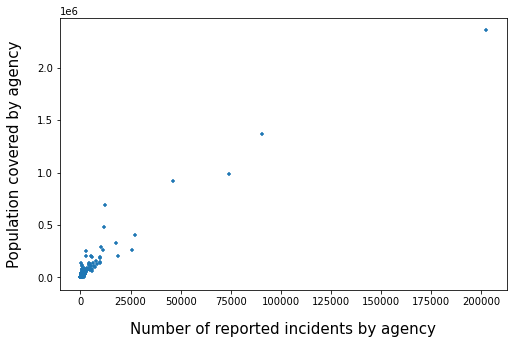

In [16]:
inc_counts = incident["AGENCY_ID"].value_counts() # counts the number of incidents associated with an agency ID
inc = pd.DataFrame(inc_counts.values, index = inc_counts.index, columns = ["NUMINC"])

# merge with other agency info
inc = pd.merge(left = inc, left_index = True, right = agencies, right_on = 'AGENCY_ID') 

fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(inc["NUMINC"], inc["POPULATION"], s = 10, marker = "+")
ax.set_xlabel("Number of reported incidents by agency", fontsize = 15, labelpad = 15)
ax.set_ylabel("Population covered by agency", fontsize = 15, labelpad = 15)
print("Number of reporting agencies: ", len(inc))

What are the outliers? 

In [17]:
inc.sort_values(axis = 0, by = "NUMINC", ascending = False)[0:10][["NUMINC", "NCIC_AGENCY_NAME","COUNTY_NAME", "NIBRS_START_DATE"]]

,NUMINC,NCIC_AGENCY_NAME,COUNTY_NAME,NIBRS_START_DATE
574,202581,HOUSTON POLICE DEPARTMENT,MONTGOMERY; FORT BEND; HARRIS,01-JUN-18
573,90375,DALLAS POLICE DEPARTMENT,DENTON; COLLIN; DALLAS,01-MAR-18
512,73972,AUSTIN PD,WILLIAMSON; TRAVIS,01-JAN-19
489,46241,FORT WORTH PD,PARKER; DENTON; TARRANT,01-OCT-05
483,27243,ARLINGTON PD,TARRANT,01-FEB-16
347,25833,LUBBOCK PD,LUBBOCK,01-OCT-17
428,18568,AMARILLO PD,RANDALL; POTTER,01-OCT-99
403,17930,CORPUS CHRISTI PD,NUECES,01-MAY-19
179,12131,EL PASO PD,EL PASO,01-JUL-19
188,11828,FORT BEND CO SO RICHMOND,FORT BEND,01-JUN-18


I see a pretty linear relationship between population covered by an agency and the number of incidents reported by that agency. What is the correlation coefficient between the two? What about correlation with the number of people employed by that agency, like the number of male/female officers or the number of total male/female employees (i.e. officers and civilians)?

In [18]:
print("Correlation matrix:")
inc[['NUMINC', 'POPULATION', 'MALE_OFFICER', 'FEMALE_OFFICER', 'PED.MALE_OFFICER+PED.MALE_CIVILIAN', 'PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER']].corr()

Correlation matrix:


,NUMINC,POPULATION,MALE_OFFICER,FEMALE_OFFICER,PED.MALE_OFFICER+PED.MALE_CIVILIAN,PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER
NUMINC,1.000000,0.958039,0.977120,0.966915,0.943237,0.901168
POPULATION,0.958039,1.000000,0.987091,0.959802,0.965904,0.935607
MALE_OFFICER,0.977120,0.987091,1.000000,0.982373,0.981042,0.949042
FEMALE_OFFICER,0.966915,0.959802,0.982373,1.000000,0.953602,0.926585
PED.MALE_OFFICER+PED.MALE_CIVILIAN,0.943237,0.965904,0.981042,0.953602,1.000000,0.986100
PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER,0.901168,0.935607,0.949042,0.926585,0.986100,1.000000


Slightly stronger correlations with number of male officers employed and number of female officers employed. 

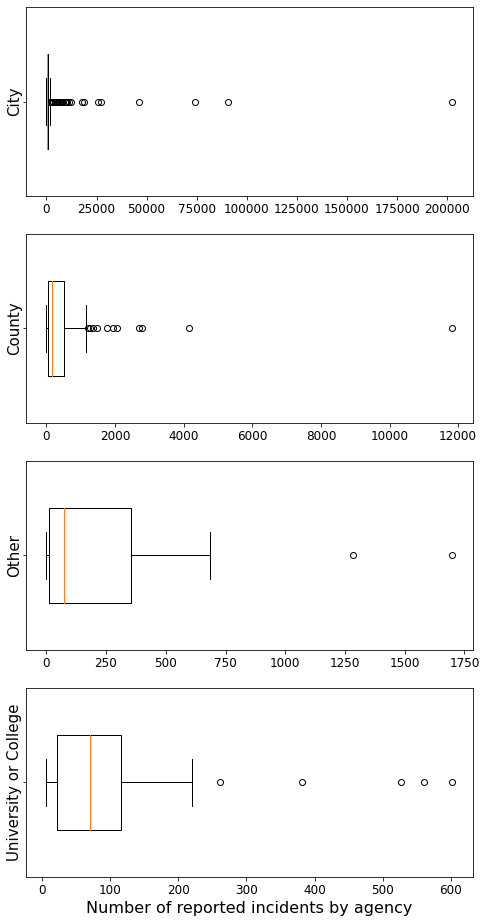

In [19]:
c = "AGENCY_TYPE_NAME"
n = len(inc[c].unique())
fig, axes = plt.subplots(n, figsize = (8, 4*n), sharex = False)
for i, each in enumerate(inc[c].unique()):
    axes[i].boxplot(inc.loc[inc[c]==each]["NUMINC"], vert = False, widths = 0.5)
    axes[i].set_ylabel(each, fontsize = 15)
    axes[i].tick_params(labelleft= False, labelsize = 12)
    
_ = axes[n-1].set_xlabel("Number of reported incidents by agency", fontsize = 16)

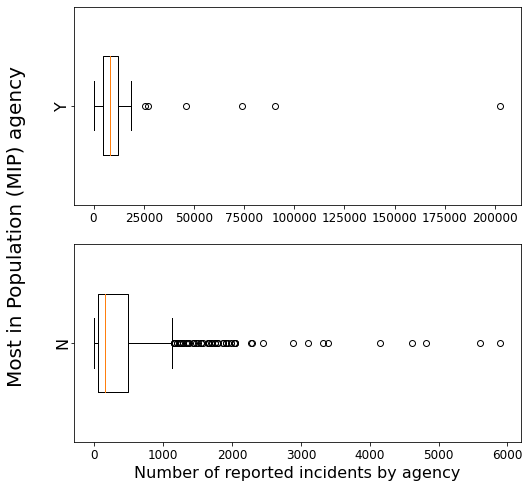

In [20]:
c = "MIP_FLAG" # indicates if an agency is a Most in Population agency (over 100,000)
n = len(inc[c].unique())
fig, axes = plt.subplots(n, figsize = (8, 4*n), sharex = False)
for i, each in enumerate(inc[c].unique()):
    axes[i].boxplot(inc.loc[inc[c]==each]["NUMINC"], vert = False, widths = 0.5)
    axes[i].set_ylabel(each, fontsize = 16)
    axes[i].tick_params(labelleft= False, labelsize = 12)
    
axes[n-1].set_xlabel("Number of reported incidents by agency", fontsize = 16)
_ = axes[0].text(-0.15,-0.9, "Most in Population (MIP) agency", transform = axes[0].transAxes, fontsize = 20, rotation = 90)

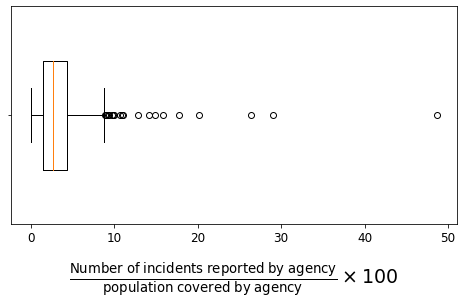

In [21]:
fig, ax = plt.subplots(figsize = (8,4))
ax.boxplot(inc.loc[inc['POPULATION']!=0]['NUMINC']/inc.loc[inc['POPULATION']!=0]['POPULATION']*100, vert = False, widths = 0.5)
ax.tick_params(labelleft = False, labelsize = 12)
_ = ax.set_xlabel(r"$\frac{\mathrm{Number\;of\;incidents\;reported\;by\;agency}}{\mathrm{population\;covered\;by \;agency}}\times 100$", fontsize = 19, labelpad = 15)

## Down to business

# CHANGE: 
### 1. Select intimate partners from victim-offender relationship records

# To: 
### 1. Select intimate partners after data is assembled

NIBRS_VICTIM_OFFENDER_REL.csv has columns `DATA_YEAR`,`VICTIM_ID`,`OFFENDER_ID`,`RELATIONSHIP_ID`,and `NIBRS_VICTIM_OFFENDER_ID`.

The values for `RELATIONSHIP_ID` are included in NIBRS_RELATIONSHIP.csv (see below)

**Question**: Should I include ex-boyfriends/ex-girlfriends and ex-spouses?

Note: Common-law marriage is a legal framework where a couple may be considered married without having formally registered their relation as a civil or religious marriage. 

From the NIBRS User Manual: 

*The agency should use the Victim Was Offender category when a participant in the incident was
a victim and offender in the incident, such as domestic disputes where both husband and wife
are charged with assault, double murders (two people kill each other), or barroom brawls
where many participants are arrested*

**Question**: Should I include cases where the victim was marked as both a victim and an offender? 


For now, I will include 
- victim was spouse (RELATIONSHIP_ID = 21)
- victim was boyfriend/girlfriend (RELATIONSHIP_ID = 3)
- victim was common-law spouse (RELATIONSHIP_ID = 6) 
- victim was offender (RELATIONSHIP_ID = 25)

I would like to include *victim was offender* cases because I do not want to exclude cases where the assault perpetrated by the victim failed to be identified as self-defense. Police response in nuanced situations is the very focus of this research project. However, I am not as interested in police response to incidents involving ex-relationships, though in general it would be another interesting factor to consider. 

-------------------

<s>1. Select intimate partners from NIBRS_VICTIM_OFFENDER_REL.csv 
- victim was spouse (RELATIONSHIP_ID = 21)
- victim was boyfriend/girlfriend (RELATIONSHIP_ID = 3)
- victim was common-law spouse (RELATIONSHIP_ID = 6) 
- victim was offender (RELATIONSHIP_ID = 25)</s>

# Victim-Offender Relationship

In [22]:
#pandas.set_option('display.max_rows', None)
rel_types = pd.read_csv(folder+"NIBRS_RELATIONSHIP.csv")
rel_types

,RELATIONSHIP_ID,RELATIONSHIP_CODE,RELATIONSHIP_NAME,RELATIONSHIP_TYPE_ID
0,27,XR,Victim Was Ex-Relationship (Ex-Boyfriend/Girlf...,2
1,1,AQ,Victim Was Acquaintance,2
2,2,BE,Victim Was Babysittee,2
3,3,BG,Victim Was Boyfriend/Girlfriend,2
4,4,CF,Victim Was Child of Boyfriend or Girlfriend,2
5,5,CH,Victim Was Child,1
6,6,CS,Victim Was Common-Law Spouse,1
7,7,EE,Victim was Employee,2
8,8,ER,Victim was Employer,2
9,9,FR,Victim Was Friend,2


In [23]:
drel_types = dict(zip(rel_types['RELATIONSHIP_ID'].to_list(),rel_types['RELATIONSHIP_NAME'].to_list()))
drel_types[21]

'Victim Was Spouse'

In [24]:
vict = pd.read_csv(folder+"NIBRS_VICTIM_OFFENDER_REL.csv")
vict.columns

Index(['DATA_YEAR', 'VICTIM_ID', 'OFFENDER_ID', 'RELATIONSHIP_ID',
       'NIBRS_VICTIM_OFFENDER_ID'],
      dtype='object')

In [25]:
# IPvict = vict.loc[(vict['RELATIONSHIP_ID']==21) | #spouse
#                     (vict['RELATIONSHIP_ID']==3) | #boyfriend/girlfriend
#                     (vict['RELATIONSHIP_ID']==6) | #common-law spouse
#                     (vict['RELATIONSHIP_ID']==25)] #victim was offender

In [26]:
# print("total no. of victim-offender relationship records in TX: ",len(vict))
# print("no. of intimate partner relationship records (including mutual offenses) in TX: ", len(IPvict), "(%.2f percent)"%(len(IPvict)/len(vict)*100))

In [27]:
# IPvict_counts = IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)['RELATIONSHIP_ID'].value_counts()
# print(IPvict_counts)

In [28]:
# fig, ax  = plt.subplots(figsize = (13,8))
# names = ["Victim was \n Boyfriend/Girfriend","Victim was \n Spouse", "Victim was \n Offender", "Victim was \n Common-Law Spouse" ]
# ax.bar(names, IPvict_counts, color = (0.5,0.3,0.5))
# ax.set_ylabel("Counts", fontsize = 15, labelpad = 15)
# ax.tick_params('both', labelsize =15)
# plt.savefig("Figures/relate_counts", bbox_inches = "tight")

## 2. Connect victims to offenses
- NIBRS_VICTIM_OFFENDER_REL.csv contains `VICTIM_ID`
- NIBRS_VICTIM_OFFENSE contains both `VICTIM_ID` and `OFFENSE_ID`
- retain `OFFENDER_ID` from NIBRS_VICTIM_OFFENDER_REL.csv so I can get information on offender later



In [29]:
offense_types = pd.read_csv(folder+"NIBRS_OFFENSE_TYPE.csv")
offense_types

,OFFENSE_TYPE_ID,OFFENSE_CODE,OFFENSE_NAME,CRIME_AGAINST,CT_FLAG,HC_FLAG,HC_CODE,OFFENSE_CATEGORY_NAME,OFFENSE_GROUP
0,58,23*,Not Specified,Property,N,Y,6.0,Larceny/Theft Offenses,A
1,1,09C,Justifiable Homicide,Person,N,N,NaN,Homicide Offenses,A
2,2,26A,False Pretenses/Swindle/Confidence Game,Property,Y,Y,NaN,Fraud Offenses,A
3,3,36B,Statutory Rape,Person,N,Y,NaN,"Sex Offenses, Non-forcible",A
4,4,11C,Sexual Assault With An Object,Person,N,Y,2.0,Sex Offenses,A
...,...,...,...,...,...,...,...,...,...
81,68,26H,Money Laundering,Society,N,N,NaN,Other Offenses,A
82,36,11A,Rape,Person,N,Y,2.0,Sex Offenses,A
83,50,23E,Theft From Coin-Operated Machine or Device,Property,N,N,NaN,Larceny/Theft Offenses,A
84,10,90D,Driving Under the Influence,Society,N,N,NaN,Driving Under the Influence,B


In [30]:
doffense_types = dict(zip(offense_types['OFFENSE_TYPE_ID'].to_list(),offense_types['OFFENSE_NAME'].to_list()))
doffense_types[2]

'False Pretenses/Swindle/Confidence Game'

See Table 1 in "HON 4355 - Project Update" for selection of UCR offense codes. It may need to be updated as appropriate, e.g. 

From [NIBRS Offense Definitions](https://ucr.fbi.gov/nibrs/2012/resources/nibrs-offense-definitions): 

**Family Offenses, Nonviolent** — Unlawful, nonviolent acts by a family member (or legal guardian)
that threaten the physical, mental, or economic well-being or morals of another family member
and that are not classifiable as other offenses, such as Assault, Incest, Statutory Rape, etc. 


In [31]:
NIBRS_victim_offense = pd.read_csv(folder+"NIBRS_VICTIM_OFFENSE.csv")

NIBRS_victim_offense.columns

Index(['DATA_YEAR', 'VICTIM_ID', 'OFFENSE_ID'], dtype='object')

From the README: 

This table maps victims to offenses and should be used to get all
victims of a specific offense associated with an incident. Do not
simply assume that all offenses associated with an incident apply to all victims.

indicates that multiple victims may be tied to a specific offense, so in this case `OFFENSE_ID` is assumed to be the unique identifier and this suggests a *many-to-one* join. However, since it is possible a single victim in an incident may be a victim of multiple offenses, a *many-to-many* join might be appropriate. It depends on whether a single victim in an incident is assigned a unique `VICTIM_ID` for each offense perpetrated against them, which I can't find a clear answer for. 

Either way, I can use `how = 'right'` to ensure that each victim in my list of IP victim-offender relationships is matched with an offense. I tried it both ways and it doesn't matter whether `how = 'inner'` or `how = 'right'` is used. 

In [32]:
vict_offense = pd.merge(left = NIBRS_victim_offense, 
                        #right = IPvict,
                        right = vict,
                        on = ['VICTIM_ID', 'DATA_YEAR'],
                        how = 'right',
)

vict_offense.columns

Index(['DATA_YEAR', 'VICTIM_ID', 'OFFENSE_ID', 'OFFENDER_ID',
       'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID'],
      dtype='object')

In [33]:
len(vict_offense)

368722

In [34]:
vict_offense[0:10]

,DATA_YEAR,VICTIM_ID,OFFENSE_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID
0,2019,126809311,140562017,131452179,24,39423392
1,2019,126809311,140562017,131452177,24,39428145
2,2019,126809311,140562017,131452178,24,39423391
3,2019,126809311,140562017,131452180,24,39423393
4,2019,126813479,140562017,131452178,24,39428146
5,2019,126813479,140562017,131452177,24,39432537
6,2019,126813479,140562017,131452179,24,39428147
7,2019,126813479,140562017,131452180,24,39423396
8,2019,126805732,140562017,131452179,24,39423399
9,2019,126805732,140562017,131452180,24,39423400


In [35]:
#print("no. of intimate partner relationship records (including mutual offenses) in TX: ", len(IPvict))
#print("no. of offense records associated with intimate partner relationship between victim-offender: ",len(vict_offense))

print("no. of relationship records in TX: ", len(vict))
print("no. of offense records associated with relationship between victim-offender: ",len(vict_offense))


no. of relationship records in TX:  353070
no. of offense records associated with relationship between victim-offender:  368722


This shows that the join is not one-to-one (i.e. more offense records that victim-offender relationship records). 


**Now let's connect this new dataframe to the NIBRS_OFFENSE.csv using** `OFFENDER_ID`

In [36]:
NIBRS_offense = pd.read_csv(folder+"NIBRS_offense.csv")
NIBRS_offense.columns

Index(['DATA_YEAR', 'OFFENSE_ID', 'INCIDENT_ID', 'OFFENSE_TYPE_ID',
       'ATTEMPT_COMPLETE_FLAG', 'LOCATION_ID', 'NUM_PREMISES_ENTERED',
       'METHOD_ENTRY_CODE'],
      dtype='object')

In [37]:
vict_offns = pd.merge(left = NIBRS_offense, 
                     right = vict_offense, 
                     on = ['DATA_YEAR','OFFENSE_ID'])
vict_offns.columns

Index(['DATA_YEAR', 'OFFENSE_ID', 'INCIDENT_ID', 'OFFENSE_TYPE_ID',
       'ATTEMPT_COMPLETE_FLAG', 'LOCATION_ID', 'NUM_PREMISES_ENTERED',
       'METHOD_ENTRY_CODE', 'VICTIM_ID', 'OFFENDER_ID', 'RELATIONSHIP_ID',
       'NIBRS_VICTIM_OFFENDER_ID'],
      dtype='object')

In [38]:
len(vict_offns)

368722

As expected, this merge just added additional information (columns) about the offense, including most notably `OFFENSE_TYPE_ID`. <s>Now I can look at the types of offenses most common when the victim-offender relationship is one between intimate partners. </s>

In [39]:
# offense_counts_total = vict_offns.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts()
# offense_counts = pd.DataFrame(offense_counts_total.to_list(), columns = ['Total'], index = offense_counts_total.index)

# for relationship_id in [21,3,6,25]:
#     tempdf = vict_offns.loc[vict_offns['RELATIONSHIP_ID']==relationship_id].replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts()
#     tempdf = pd.DataFrame(tempdf.to_list(), columns = [drel_types[relationship_id]], index = tempdf.index)
#     offense_counts = pd.merge(offense_counts, tempdf, left_index = True, right_index = True)

In [40]:
# # counts of offenses
# offense_counts

In [41]:
# offense_props_total = vict_offns.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts(normalize = True)
# offense_props = pd.DataFrame(offense_props_total.to_list(), columns = ['Total'], index = offense_props_total.index)

# for relationship_id in [21,3,6,25]:
#     tempdf = vict_offns.loc[vict_offns['RELATIONSHIP_ID']==relationship_id].replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts(normalize = True)
#     tempdf = pd.DataFrame(tempdf.to_list(), columns = [drel_types[relationship_id]], index = tempdf.index)
#     offense_props = pd.merge(offense_props, tempdf, left_index = True, right_index = True)

In [42]:
# # types of offenses compared by proportion of all offenses (between intimate partners)
# offense_props

In [43]:
# fig, ax = plt.subplots(figsize = (12,8))
# left = 0
# for relationship_id in [21,3,6,25]:
#     relationship_type = drel_types[relationship_id]
#     ax.barh(offense_counts.index.to_list(), offense_counts[relationship_type], left = left, label = relationship_type)
#     left+=offense_counts[relationship_type]
# ax.legend(fontsize = 15)
# ax.set_xlabel("Counts", fontsize = 14, labelpad = 15)
# ax.tick_params('both', labelsize =14)
# plt.savefig("Figures/offense_type_counts", bbox_inches = 'tight')

In [44]:
# fig, ax = plt.subplots(figsize = (12,8))
# left = 0
# for relationship_id in [21,3,6,25]:
#     relationship_type = drel_types[relationship_id]
#     ax.barh(offense_counts.index.to_list()[4:], offense_counts[relationship_type][4:], left = left, label = relationship_type)
#     left+=offense_counts[relationship_type][4:]
# ax.legend(fontsize = 15)
# ax.set_xlabel("Counts", fontsize = 14, labelpad = 15)
# ax.tick_params('both', labelsize =14)


In [45]:
# fig, ax = plt.subplots(figsize = (12,8))
# left = 0
# for relationship_id in [21,3,6,25]:
#     relationship_type = drel_types[relationship_id]
#     ax.barh(offense_props.index.to_list(), offense_props[relationship_type], left = left, label = relationship_type)
#     left+=offense_props[relationship_type]
# ax.legend(fontsize = 15)
# #ax.set_ylabel("Y", fontsize = 19)
# ax.set_xlabel("Relative frequency", fontsize = 14, labelpad = 15)
# ax.tick_params('both', labelsize =14)
# plt.savefig("Figures/offense_type_norm", bbox_inches = 'tight')

In [46]:
# fig, ax = plt.subplots(figsize = (12,8))
# left = 0
# for relationship_id in [21,3,6,25]:
#     relationship_type = drel_types[relationship_id]
#     ax.barh(offense_props.index.to_list()[4:], offense_props[relationship_type][4:], left = left, label = relationship_type)
#     left+=offense_props[relationship_type][4:]
# ax.legend(fontsize = 15)
# ax.set_xlabel("Relative frequency", fontsize = 14, labelpad = 15)
# ax.tick_params('both', labelsize =14)
# plt.savefig("Figures/offense_type_norm_zoom", bbox_inches = 'tight')

<s>Interesting to note that the only offense where victims were more commonly spouses than boyfriends/girlfriends is murder and nonnegligent manslaughter (39 incidents where victim was spouse versus 38 where victim was boyfriend/girlfriend) </s>. 

## Add Victim and Offender information (e.g., age, sex, race)
- merge on `VICTIM_ID` and `INCIDENT_ID`
- merge on `OFFENDER_ID` and `INCIDENT_ID`

In [47]:
NIBRS_victim = pd.read_csv(folder+"NIBRS_victim.csv")
NIBRS_victim.columns

Index(['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID', 'VICTIM_SEQ_NUM',
       'VICTIM_TYPE_ID', 'ASSIGNMENT_TYPE_ID', 'ACTIVITY_TYPE_ID',
       'OUTSIDE_AGENCY_ID', 'AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID',
       'ETHNICITY_ID', 'RESIDENT_STATUS_CODE', 'AGE_RANGE_LOW_NUM',
       'AGE_RANGE_HIGH_NUM'],
      dtype='object')

Something different from the ICPSR distribution is that age is given via two variables as a range instead of being given as a single value. I don't expect this to be an issue since I'm dealing with intimate partner relationships. Here's what `AGE_ID` corresponds to:

In [48]:
pd.read_csv(folder + "NIBRS_AGE.csv")

,AGE_ID,AGE_CODE,AGE_NAME
0,1,NN,Under 24 Hours
1,2,NB,1-6 Days Old
2,3,BB,7-364 Days Old
3,4,00,Unknown
4,5,AG,Age in Years
5,6,99,Over 98 Years Old
6,0,NS,Not Specified


If the age is known , it's given by `AGE_RANGE_LOW_NUM` or, equivalently, `AGE_NUM`. If `AGE_ID` is anything other than 5, `AGE_NUM`,`AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` are all NaN. If `AGE_ID` is 5, `AGE_RANGE_HIGH_NUM` can be either 0 (if exact age is known) or greater than `AGE_RANGE_LOW_NUM` (thus giving an age range). 

In [49]:
NIBRS_victim[["AGE_ID", 'AGE_NUM','AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']][0:10]

,AGE_ID,AGE_NUM,AGE_RANGE_LOW_NUM,AGE_RANGE_HIGH_NUM
0,5.0,35.0,35.0,0.0
1,5.0,25.0,25.0,0.0
2,5.0,57.0,57.0,0.0
3,5.0,34.0,34.0,0.0
4,5.0,37.0,37.0,0.0
5,5.0,47.0,47.0,0.0
6,5.0,63.0,63.0,0.0
7,NaN,NaN,NaN,NaN
8,5.0,79.0,79.0,0.0
9,5.0,27.0,27.0,0.0


In [50]:
NIBRS_victim[["AGE_ID",'AGE_NUM', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']].loc[NIBRS_victim['AGE_RANGE_HIGH_NUM']>0][0:10]

,AGE_ID,AGE_NUM,AGE_RANGE_LOW_NUM,AGE_RANGE_HIGH_NUM
375,5.0,58.0,18.0,99.0
1132,5.0,62.0,60.0,65.0
1454,5.0,38.0,12.0,65.0
2889,5.0,44.0,40.0,49.0
2924,5.0,15.0,15.0,16.0
3257,5.0,9.0,1.0,17.0
3917,5.0,58.0,17.0,99.0
4060,5.0,60.0,21.0,99.0
4268,5.0,15.0,10.0,20.0
4445,5.0,68.0,67.0,70.0


If an age range is given (i.e. exact age is NOT known), then `AGE_NUM` is given as the midpoint of the range, rounding down to the nearest whole integer, i.e. 
```
if AGE_RANGE_HIGH_NUM>0:
    `AGE_NUM` = math.floor( (AGE_RANGE_LOW_NUM + AGE_RANGE_HIGH_NUM)/2 )
```

A little bit farther down I create variables `VICTIM_AGE` and `OFFENDER_AGE` to simplify things a bit further: these variables give the age as a single value if age is known, and -99 otherwise. I do this because I assume that the ages of the victim(s)/offender(s) will be known in a large majority of -- if not all -- IPV incidents. 

In [51]:
VO1 = pd.merge(left = vict_offns,
              right = NIBRS_victim, 
              on = ['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID'])
print("in previous dataset, n = ", len(vict_offns))
print("in new dataset, n = ", len(VO1))
VO1.columns

in previous dataset, n =  368722
in new dataset, n =  368722


Index(['DATA_YEAR', 'OFFENSE_ID', 'INCIDENT_ID', 'OFFENSE_TYPE_ID',
       'ATTEMPT_COMPLETE_FLAG', 'LOCATION_ID', 'NUM_PREMISES_ENTERED',
       'METHOD_ENTRY_CODE', 'VICTIM_ID', 'OFFENDER_ID', 'RELATIONSHIP_ID',
       'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_SEQ_NUM', 'VICTIM_TYPE_ID',
       'ASSIGNMENT_TYPE_ID', 'ACTIVITY_TYPE_ID', 'OUTSIDE_AGENCY_ID', 'AGE_ID',
       'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID',
       'RESIDENT_STATUS_CODE', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM'],
      dtype='object')

In [52]:
NIBRS_offender = pd.read_csv(folder + "NIBRS_offender.csv")
NIBRS_offender.columns

Index(['DATA_YEAR', 'OFFENDER_ID', 'INCIDENT_ID', 'OFFENDER_SEQ_NUM', 'AGE_ID',
       'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM',
       'AGE_RANGE_HIGH_NUM'],
      dtype='object')

In [53]:
# for each in NIBRS_offender.columns.to_list():
#     if each in NIBRS_victim.columns.to_list():
#         print(each)

The same variable names `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, `AGE_RANGE_HIGH_NUM` are used in both NIBRS_victim.csv and NIBRS_offender.csv

So I'll have to rename the variables before merging. 

In [54]:
vmap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    vmap[each] = 'VICTIM_'+each


NIBRS_victim2 = NIBRS_victim.rename(columns = vmap)
NIBRS_victim2.columns

Index(['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID', 'VICTIM_SEQ_NUM',
       'VICTIM_TYPE_ID', 'ASSIGNMENT_TYPE_ID', 'ACTIVITY_TYPE_ID',
       'OUTSIDE_AGENCY_ID', 'VICTIM_AGE_ID', 'VICTIM_AGE_NUM',
       'VICTIM_SEX_CODE', 'VICTIM_RACE_ID', 'VICTIM_ETHNICITY_ID',
       'RESIDENT_STATUS_CODE', 'VICTIM_AGE_RANGE_LOW_NUM',
       'VICTIM_AGE_RANGE_HIGH_NUM'],
      dtype='object')

In [55]:
# redo victim info merge with new column names
VO1 = pd.merge(left = vict_offns,
              right = NIBRS_victim2, 
              on = ['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID'])
print("in previous dataset, n = ", len(vict_offns))
print("in new dataset, n = ", len(VO1))
VO1.columns

in previous dataset, n =  368722
in new dataset, n =  368722


Index(['DATA_YEAR', 'OFFENSE_ID', 'INCIDENT_ID', 'OFFENSE_TYPE_ID',
       'ATTEMPT_COMPLETE_FLAG', 'LOCATION_ID', 'NUM_PREMISES_ENTERED',
       'METHOD_ENTRY_CODE', 'VICTIM_ID', 'OFFENDER_ID', 'RELATIONSHIP_ID',
       'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_SEQ_NUM', 'VICTIM_TYPE_ID',
       'ASSIGNMENT_TYPE_ID', 'ACTIVITY_TYPE_ID', 'OUTSIDE_AGENCY_ID',
       'VICTIM_AGE_ID', 'VICTIM_AGE_NUM', 'VICTIM_SEX_CODE', 'VICTIM_RACE_ID',
       'VICTIM_ETHNICITY_ID', 'RESIDENT_STATUS_CODE',
       'VICTIM_AGE_RANGE_LOW_NUM', 'VICTIM_AGE_RANGE_HIGH_NUM'],
      dtype='object')

In [56]:
omap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    omap[each] = 'OFFENDER_'+each
    
NIBRS_offender2 = NIBRS_offender.rename(columns = omap)
NIBRS_offender2.columns


Index(['DATA_YEAR', 'OFFENDER_ID', 'INCIDENT_ID', 'OFFENDER_SEQ_NUM',
       'OFFENDER_AGE_ID', 'OFFENDER_AGE_NUM', 'OFFENDER_SEX_CODE',
       'OFFENDER_RACE_ID', 'OFFENDER_ETHNICITY_ID',
       'OFFENDER_AGE_RANGE_LOW_NUM', 'OFFENDER_AGE_RANGE_HIGH_NUM'],
      dtype='object')

In [57]:
VO2 = pd.merge(left = VO1, 
              right = NIBRS_offender2, 
              on = ['DATA_YEAR', 'OFFENDER_ID', 'INCIDENT_ID'])
print("in new dataset, n = ",len(VO2))
VO2.columns

in new dataset, n =  368722


Index(['DATA_YEAR', 'OFFENSE_ID', 'INCIDENT_ID', 'OFFENSE_TYPE_ID',
       'ATTEMPT_COMPLETE_FLAG', 'LOCATION_ID', 'NUM_PREMISES_ENTERED',
       'METHOD_ENTRY_CODE', 'VICTIM_ID', 'OFFENDER_ID', 'RELATIONSHIP_ID',
       'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_SEQ_NUM', 'VICTIM_TYPE_ID',
       'ASSIGNMENT_TYPE_ID', 'ACTIVITY_TYPE_ID', 'OUTSIDE_AGENCY_ID',
       'VICTIM_AGE_ID', 'VICTIM_AGE_NUM', 'VICTIM_SEX_CODE', 'VICTIM_RACE_ID',
       'VICTIM_ETHNICITY_ID', 'RESIDENT_STATUS_CODE',
       'VICTIM_AGE_RANGE_LOW_NUM', 'VICTIM_AGE_RANGE_HIGH_NUM',
       'OFFENDER_SEQ_NUM', 'OFFENDER_AGE_ID', 'OFFENDER_AGE_NUM',
       'OFFENDER_SEX_CODE', 'OFFENDER_RACE_ID', 'OFFENDER_ETHNICITY_ID',
       'OFFENDER_AGE_RANGE_LOW_NUM', 'OFFENDER_AGE_RANGE_HIGH_NUM'],
      dtype='object')

Just to make things a bit easier, I will create variables `OFFENDER_AGE` and `VICTIM_AGE` for cases where the exact age is known. 

In [58]:
VO2['OFFENDER_AGE'] = np.where((VO2['OFFENDER_AGE_ID']==5)&(VO2['OFFENDER_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['OFFENDER_AGE_RANGE_LOW_NUM'], 
                              -99)

VO2['VICTIM_AGE'] = np.where((VO2['VICTIM_AGE_ID']==5)&(VO2['VICTIM_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['VICTIM_AGE_RANGE_LOW_NUM'], 
                              -99)

## Merging with incident data

The arrestee data is connected with `INCIDENT_ID`, so in order to get information on whether or not an arrest occurred, I must merge the offense data with incident data. 

In [59]:
## double check I didn't miss any variables present in both VO2 and NIBRS_incident
# for each in VO2.columns.to_list():
#     if each in NIBRS_incident.columns.to_list():
#         print(each)

In [60]:
# IVO = incident, victim, offender
IVO = pd.merge(left = NIBRS_incident, 
        right = VO2, 
        on = ['DATA_YEAR', 'INCIDENT_ID'],
        how = "inner") # how = 'right' produces the same result
print(len(vict_offns))
print(len(IVO))
IVO.columns

368722
368722


Index(['DATA_YEAR', 'AGENCY_ID', 'INCIDENT_ID', 'NIBRS_MONTH_ID',
       'CARGO_THEFT_FLAG', 'SUBMISSION_DATE', 'INCIDENT_DATE',
       'REPORT_DATE_FLAG', 'INCIDENT_HOUR', 'CLEARED_EXCEPT_ID',
       'CLEARED_EXCEPT_DATE', 'INCIDENT_STATUS', 'DATA_HOME', 'ORIG_FORMAT',
       'DID', 'OFFENSE_ID', 'OFFENSE_TYPE_ID', 'ATTEMPT_COMPLETE_FLAG',
       'LOCATION_ID', 'NUM_PREMISES_ENTERED', 'METHOD_ENTRY_CODE', 'VICTIM_ID',
       'OFFENDER_ID', 'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID',
       'VICTIM_SEQ_NUM', 'VICTIM_TYPE_ID', 'ASSIGNMENT_TYPE_ID',
       'ACTIVITY_TYPE_ID', 'OUTSIDE_AGENCY_ID', 'VICTIM_AGE_ID',
       'VICTIM_AGE_NUM', 'VICTIM_SEX_CODE', 'VICTIM_RACE_ID',
       'VICTIM_ETHNICITY_ID', 'RESIDENT_STATUS_CODE',
       'VICTIM_AGE_RANGE_LOW_NUM', 'VICTIM_AGE_RANGE_HIGH_NUM',
       'OFFENDER_SEQ_NUM', 'OFFENDER_AGE_ID', 'OFFENDER_AGE_NUM',
       'OFFENDER_SEX_CODE', 'OFFENDER_RACE_ID', 'OFFENDER_ETHNICITY_ID',
       'OFFENDER_AGE_RANGE_LOW_NUM', 'OFFENDER_AGE_RANGE_HI

Now I have to figure out how to address this:

In [61]:
print("number of rows in dataset: ",len(IVO))
print("number of unique incidents in dataset: ",len(IVO['INCIDENT_ID'].unique()))

number of rows in dataset:  368722
number of unique incidents in dataset:  245295


In [62]:
# find distribution of no. of appearances of incident_id in the data
print("How many incident_id's (count) appear (X) times?\n")
print("%.10s %11s\n---------------"%('X', 'count'))
distribution = IVO['INCIDENT_ID'].value_counts().value_counts()
for i, each in enumerate(distribution):
    print("%d\t%d"%(distribution.index.to_list()[i], each))

How many incident_id's (count) appear (X) times?

X       count
---------------
1	188615
2	33453
4	10486
3	6789
6	2487
8	870
5	791
9	435
12	370
10	284
16	132
7	130
15	106
20	75
24	53
18	52
14	42
25	19
21	17
30	16
36	8
32	8
28	8
27	7
11	5
22	4
40	4
42	4
49	4
48	3
17	2
35	2
60	2
46	1
129	1
58	1
57	1
44	1
45	1
64	1
41	1
1035	1
13	1
33	1
81	1


The majority of incidents only appear once, but some appear multiple times (i.e. due to multiple victims or offenses). I'll create a variable (`INC_APPEARS`) to indicate how many times the incident ID is repeated in the current dataset and then explore. 

In [63]:
nappears = IVO['INCIDENT_ID'].value_counts()
#IVO.set_index('INCIDENT_ID', inplace = True)
temp = pd.DataFrame(nappears.values, index = nappears.index, columns = ['INC_APPEARS'])
IVO = pd.merge(left = IVO, right = temp, right_index = True, left_on = 'INCIDENT_ID', how = 'inner')
print(len(IVO))

368722


Let's look at some examples where `INC_APPEARS` $>1$

In [64]:
IVO.loc[IVO['INC_APPEARS']>1][0:10]

,DATA_YEAR,AGENCY_ID,INCIDENT_ID,NIBRS_MONTH_ID,CARGO_THEFT_FLAG,SUBMISSION_DATE,INCIDENT_DATE,REPORT_DATE_FLAG,INCIDENT_HOUR,CLEARED_EXCEPT_ID,...,OFFENDER_AGE_ID,OFFENDER_AGE_NUM,OFFENDER_SEX_CODE,OFFENDER_RACE_ID,OFFENDER_ETHNICITY_ID,OFFENDER_AGE_RANGE_LOW_NUM,OFFENDER_AGE_RANGE_HIGH_NUM,OFFENDER_AGE,VICTIM_AGE,INC_APPEARS
10,2019,19658,112978525,9131075,NaN,25-JUL-19,28-JUN-19,NaN,10.0,6,...,5.0,18.0,M,1.0,1.0,18.0,0.0,18.0,53.0,2
11,2019,19658,112978525,9131075,NaN,25-JUL-19,28-JUN-19,NaN,10.0,6,...,5.0,18.0,M,1.0,1.0,18.0,0.0,18.0,66.0,2
28,2019,19658,111280695,9002620,NaN,22-MAY-19,31-JAN-19,NaN,22.0,6,...,5.0,28.0,M,1.0,1.0,28.0,0.0,28.0,39.0,2
29,2019,19658,111280695,9002620,NaN,22-MAY-19,31-JAN-19,NaN,22.0,6,...,5.0,38.0,F,1.0,1.0,38.0,0.0,38.0,39.0,2
33,2019,19658,111286443,9001548,NaN,22-MAY-19,03-FEB-19,NaN,11.0,6,...,5.0,28.0,M,1.0,1.0,28.0,0.0,28.0,32.0,2
34,2019,19658,111286443,9001548,NaN,22-MAY-19,03-FEB-19,NaN,11.0,6,...,5.0,28.0,M,1.0,1.0,28.0,0.0,28.0,32.0,2
39,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,32.0,8
40,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8
41,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8
42,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8


So the first three rows are from the same incident

In [65]:
# as a quick check that these rows are indeed all incidents in the dataset with this incident ID 
IVO.loc[IVO['INCIDENT_ID']==111286451]

,DATA_YEAR,AGENCY_ID,INCIDENT_ID,NIBRS_MONTH_ID,CARGO_THEFT_FLAG,SUBMISSION_DATE,INCIDENT_DATE,REPORT_DATE_FLAG,INCIDENT_HOUR,CLEARED_EXCEPT_ID,...,OFFENDER_AGE_ID,OFFENDER_AGE_NUM,OFFENDER_SEX_CODE,OFFENDER_RACE_ID,OFFENDER_ETHNICITY_ID,OFFENDER_AGE_RANGE_LOW_NUM,OFFENDER_AGE_RANGE_HIGH_NUM,OFFENDER_AGE,VICTIM_AGE,INC_APPEARS
39,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,32.0,8
40,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8
41,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8
42,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,22.0,F,1.0,1.0,22.0,0.0,22.0,22.0,8
43,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,32.0,M,1.0,1.0,32.0,0.0,32.0,32.0,8
44,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,32.0,M,1.0,1.0,32.0,0.0,32.0,22.0,8
45,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,32.0,M,1.0,1.0,32.0,0.0,32.0,22.0,8
46,2019,19658,111286451,9002621,NaN,22-MAY-19,06-MAR-19,NaN,16.0,6,...,5.0,32.0,M,1.0,1.0,32.0,0.0,32.0,22.0,8


#### Example 1

In [66]:
colselect = ['INCIDENT_ID', 'OFFENSE_TYPE_ID', 'LOCATION_ID', 'VICTIM_ID', 'OFFENDER_ID', 
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', 'INC_APPEARS']

location_types = pd.read_csv(folder+"NIBRS_LOCATION_TYPE.csv")
dlocation_type = dict(zip(location_types["LOCATION_ID"], location_types['LOCATION_NAME']))
IVO[colselect].loc[IVO['INCIDENT_ID']==111286451].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})


,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS
39,111286451,Simple Assault,Residence/Home,122650822,126082413,Relationship Unknown,37736681,32.0,M,22.0,F,8
40,111286451,Simple Assault,Residence/Home,122650826,126082413,Victim Was Offender,37741013,22.0,F,22.0,F,8
41,111286451,Destruction/Damage/Vandalism of Property,Highway/Road/Alley/Street/Sidewalk,122650826,126082413,Victim Was Offender,37741013,22.0,F,22.0,F,8
42,111286451,Simple Assault,Residence/Home,122654703,126082413,Victim Was Friend,37736683,22.0,F,22.0,F,8
43,111286451,Simple Assault,Residence/Home,122650822,126082414,Victim Was Offender,37736682,32.0,M,32.0,M,8
44,111286451,Simple Assault,Residence/Home,122650826,126082414,Relationship Unknown,37741014,22.0,F,32.0,M,8
45,111286451,Destruction/Damage/Vandalism of Property,Highway/Road/Alley/Street/Sidewalk,122650826,126082414,Relationship Unknown,37741014,22.0,F,32.0,M,8
46,111286451,Simple Assault,Residence/Home,122654703,126082414,Victim Was Other Family Member,37736684,22.0,F,32.0,M,8


<s>Because each relationship is listed as victim was offender, we don't know the relationship between the two people involved (two distinct `VICTIM_ID` values and and two distinct `OFFENDER_ID` values). I'll find another example. </s>

Same incident as above, I was just missing the extra relationships, because I excluded them! (DUH)

In [67]:
# IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(10)

#### Example 2

In [68]:
colselect = colselect + ['ATTEMPT_COMPLETE_FLAG']
IVO[colselect].loc[IVO['INCIDENT_ID']==112935881].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
314499,112935881,Simple Assault,Grocery/Supermarket,124512128,128011053,Victim Was Boyfriend/Girlfriend,38500449,29.0,M,19.0,F,4,C
314500,112935881,Simple Assault,Grocery/Supermarket,124512129,128011053,Victim Was Offender,38500451,19.0,F,19.0,F,4,C
314501,112935881,Simple Assault,Grocery/Supermarket,124512128,128002674,Victim Was Offender,38500448,29.0,M,29.0,M,4,C
314502,112935881,Simple Assault,Grocery/Supermarket,124512129,128002674,Victim Was Boyfriend/Girlfriend,38500450,19.0,F,29.0,M,4,C


This is a better example of how I saw "Victim Was Offender" used. Both a female (age 19) and a male (age 29) committed simple assault against the other at a grocery/supermarket. Here I'm using "male"/ "female" to refer to person's sex, which may or may not be the same as that person's gender. 

#### Example 3

In [69]:
# IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(1)['INCIDENT_ID'].values[0]

In [70]:
IVO[colselect].loc[IVO['INCIDENT_ID']==116762327].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
361332,116762327,Simple Assault,Hotel/Motel/Etc.,127910690,132706976,Victim Was Offender,39905965,50.0,M,50.0,M,4,C
361333,116762327,Simple Assault,Hotel/Motel/Etc.,127910687,132706976,Victim Was Spouse,39905963,51.0,F,50.0,M,4,C
361334,116762327,Simple Assault,Hotel/Motel/Etc.,127910690,132706977,Victim Was Spouse,39905966,50.0,M,51.0,F,4,C
361335,116762327,Simple Assault,Hotel/Motel/Etc.,127910687,132706977,Victim Was Offender,39905964,51.0,F,51.0,F,4,C


Here is another example similar to that above. Both husband and wife are reported as committing simple assault against the other, with the incident taking place in a hotel/motel/etc. 

#### Example 4

In [71]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(1, random_state = 2)['INCIDENT_ID'].values[0]
incnum = 116790257
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
95427,116790257,Destruction/Damage/Vandalism of Property,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,3,C
95428,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,3,C
95429,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946555,132740869,Victim Was Acquaintance,39927731,3.0,M,28.0,M,3,C


<s> Here is an example with a single victim and two offenses. The male offender (age 28) who is the boyfriend of the female victim (age 24), committed aggravated assault and destruction/damage/vandalism of property in a parking/drop lot/garage. </s>

Male offender (age 28) who is the boyfriend of female victim (age 24) committed aggravated assault and destruction/damage/vandalism of property against the female victim and aggravated assault against a 3 year old male victim listed as the acquaintance of this male offender. Since *Victim was child of boyfriend/girlfriend* is a relationship category, the data suggests that the 3 year old is not the child of the offender's girlfriend. 

#### Example 5

In [72]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']==6].sample(1, random_state = 25)['INCIDENT_ID'].values[0]
incnum = 116757663
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
361230,116757663,Destruction/Damage/Vandalism of Property,Residence/Home,127906716,132707044,Victim Was Boyfriend/Girlfriend,39911754,24.0,F,30.0,M,6,C
361231,116757663,Simple Assault,Residence/Home,127906716,132707044,Victim Was Boyfriend/Girlfriend,39911754,24.0,F,30.0,M,6,C
361232,116757663,Simple Assault,Residence/Home,127910759,132707044,Victim Was Boyfriend/Girlfriend,39906000,30.0,M,30.0,M,6,C
361233,116757663,Destruction/Damage/Vandalism of Property,Residence/Home,127906716,132703169,Victim Was Boyfriend/Girlfriend,39911753,24.0,F,24.0,F,6,C
361234,116757663,Simple Assault,Residence/Home,127906716,132703169,Victim Was Boyfriend/Girlfriend,39911753,24.0,F,24.0,F,6,C
361235,116757663,Simple Assault,Residence/Home,127910759,132703169,Victim Was Boyfriend/Girlfriend,39911755,30.0,M,24.0,F,6,C


This one seems like it may be a case of 'Victim was Offender' but where `RELATIONSHIP_ID` was not used properly. What this reads as technically is simple assault and destruction/damge/vandalism of property was committed against female A (24 yrs) by both female A's boyfriend (male A, 30 yrs) and female A's girlfriend (female B, 24 yrs). Additionally, female B committed simple assault against a boyfriend (male B, 30 yrs) and male A committed simple assualt against a boyfriend (male B). It is of course possible this rectangle of relationships was the case, but it seems <font color = 'red'>suspicious</font> that the necessary two females involved are both 24 years old and two males involved are both 30 years old. 

female A is dating male A and female B

female B is dating male B and female A

male A  is dating male B and female A

male B is dating male A and female B

#### Example 6

In [73]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']==6].sample(1, random_state = 1)['INCIDENT_ID'].values[0]
incnum = 116780954
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
91566,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935113,132737615,Victim Was Other Family Member,39919864,36.0,F,16.0,F,12,C
91567,116780954,Intimidation,Residence/Home,127935113,132737615,Victim Was Other Family Member,39919864,36.0,F,16.0,F,12,C
91568,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935111,132737615,Victim Was Boyfriend/Girlfriend,39919860,18.0,M,16.0,F,12,C
91569,116780954,Intimidation,Residence/Home,127935111,132737615,Victim Was Boyfriend/Girlfriend,39919860,18.0,M,16.0,F,12,C
91570,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935112,132737615,Victim Was Offender,39919861,16.0,F,16.0,F,12,C
91571,116780954,Intimidation,Residence/Home,127935112,132737615,Victim Was Offender,39919861,16.0,F,16.0,F,12,C
91572,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935113,132737614,Victim Was Offender,39919863,36.0,F,36.0,F,12,C
91573,116780954,Intimidation,Residence/Home,127935113,132737614,Victim Was Offender,39919863,36.0,F,36.0,F,12,C
91574,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935111,132737614,Victim Was Child,39919859,18.0,M,36.0,F,12,C
91575,116780954,Intimidation,Residence/Home,127935111,132737614,Victim Was Child,39919859,18.0,M,36.0,F,12,C


<s> One victim, male A (age 18), experienced intimidation and destruction/damage/vandalism of property committed by female A (age 16), who is male A's girlfriend. Female A likewise experienced intimidation and destruction/damage/vandalism of property committed by male A. Female B (age 36) played some role in the intimidation and destruction/damage/vandalism of property, but their relationship to male A or female A is not clear as this is written. </s>

Looks complicated to sort out at first. Two offenders (two unique `OFFENDER_ID`'s) and three victims (three unique `VICTIM_ID`'s). Each offender committed the same two offenses (intimidation and destruction/damage/vandalism of property) against each of the victims, i.e. 6 offense counts for each offender, noting that one of the victims is *Victim Was Offender*. We can go to the *Victim Was Offender* row to find the `VICTIM_ID` corresponding to the `OFFENDER_ID`, and see that the two offenders (one female, 16 years old and the other female 36 years old) were related as *other family member*. 
The 36 year old female offender and 16 year old female offender committed both offenses against eachother; they also committed both offenses against an 18 year old male, who was the boyfriend of the 16 year old offender and the son of the 36 year old offender. 

### Thought
Update criteria so that Victim is Offender incidents may be if one of the other IP relationships (spouse, common-law spouse, boyfriend/girlfriend) is also tied to the incident (or better yet, the specific victim/offender IDs). Justification provided by Example 1 above.  

## Add arrest file

The associated files are 
- NIBRS_ARRESTEE.csv: tracks arrests related to incidents 
- NIBRS_ARRESTEE_WEAPON.csv: lists arrestees' weapon(s), if included in incident
    - includes `ARRESTEE_ID` as reference to NIBRS_ARRESTEE.csv    
- NIBRS_ARREST_TYPE.csv: reference for `ARREST_TYPE_ID` in  NIBRS_ARRESTEE.csv
- NIBRS_WEAPON.csv: reference for `WEAPON_ID` in NIBRS_ARRESTEE_WEAPON.csv

For now, I will only merge NIBRS_ARRESTEE.csv and not include the arrestee weapon table. 

In [74]:
arrest_types = pd.read_csv(folder + "NIBRS_ARREST_TYPE.csv")
arrest_types

,ARREST_TYPE_ID,ARREST_TYPE_CODE,ARREST_TYPE_NAME
0,1,O,On View
1,2,S,Summoned / Cited
2,3,T,Taken INTO Custody


In [75]:
darrest_types = dict(zip(arrest_types['ARREST_TYPE_ID'].to_list(),arrest_types['ARREST_TYPE_CODE'].to_list()))

From [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf):

- **O = On-View Arrest** (taken into custody without a warrant or previous incident report)
    - Example (1): A female was arrested without a warrant while soliciting for prostitution on a street corner. The entry should be O = On-View Arrest.
- **S = Summoned/Cited** (not taken into custody)
    - Example (2): A man was served with a subpoena summoning him to appear in court. The entry should be S = Summoned/Cited.
- **T = Taken Into Custody** (based on warrant and/or previously submitted incident report)
    - Example (3): A suspect was taken into custody as the result of a complaint being filed, an investigation being conducted, and a warrant being issued. The entry should be T = Taken Into Custody.

In [76]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")
NIBRS_arrest.columns

Index(['DATA_YEAR', 'ARRESTEE_ID', 'INCIDENT_ID', 'ARRESTEE_SEQ_NUM',
       'ARREST_DATE', 'ARREST_TYPE_ID', 'MULTIPLE_INDICATOR',
       'OFFENSE_TYPE_ID', 'AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID',
       'ETHNICITY_ID', 'RESIDENT_CODE', 'UNDER_18_DISPOSITION_CODE',
       'CLEARANCE_IND', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM'],
      dtype='object')

From [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf):

***44 Multiple Arrestee Segments Indicator*** - *one character (A): This data element should be
used to ensure that an arrestee is counted (scored) only once when the arrestee’s apprehension causes
the arresting agency to submit two or more Arrestee Segments concerning separate Group “A” Incident
Reports. That is, the arrestee was involved in more than one crime incident and his/her arrest data are
duplicated in each Group “A” Incident Report. In such a situation, C = Count Arrestee should be
entered into one of the Arrestee Segments, and M = Multiple should be entered into all of the remaining
Arrestee Segments. If the arrestee’s apprehension does not cause the arresting agency to submit
multiple Arrestee Segments, N = Not Applicable should be entered.* 

(corresponds to `MULTIPLE_INDICATOR`)

`RESIDENT_CODE` corresponds to resident status of arrestee, i.e whether or not the arrestee maintains his/her permanent home for legal purposes in the locality (i.e., town, city, or community) where the crime took place, not to be confused with the the `RESIDENT_STATUS_CODE` of the victim. 

I'll rename variableS `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` for clarity and consistency with existing variable names like `VICTIM_AGE_ID` and `OFFENDER_AGE_ID`. I will also create a variable `ARRESTEE_AGE` to be consistent with previously created variables `VICTIM_AGE` and `OFFENDER_AGE`. 

In [77]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")

# rename existing variables
amap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    amap[each] = 'ARRESTEE_'+each
NIBRS_arrest = NIBRS_arrest.rename(columns = amap)

# generate new variable `ARRESTEE_AGE`
NIBRS_arrest['ARRESTEE_AGE'] = np.where((NIBRS_arrest['ARRESTEE_AGE_ID']==5) &
                                       (NIBRS_arrest['ARRESTEE_AGE_RANGE_HIGH_NUM']==0), 
                                       NIBRS_arrest['ARRESTEE_AGE_RANGE_LOW_NUM'], -99)

In [78]:
IVOA = pd.merge(left = IVO,
               right = NIBRS_arrest,
               on = ['DATA_YEAR', 'INCIDENT_ID', 'OFFENSE_TYPE_ID'], 
               how = "left") # left merge since **not all incidents will have an associated arrest record**

print("previous dataframe, n = ", len(IVO))
print("new dataframe, n = ", len(IVOA))
print("number of unique incidents in previous dataframe: ",len(IVO['INCIDENT_ID'].unique()))
print("number of unique incidents in new dataframe: ",len(IVOA['INCIDENT_ID'].unique()))

previous dataframe, n =  368722
new dataframe, n =  381752
number of unique incidents in previous dataframe:  245295
number of unique incidents in new dataframe:  245295


I will also update `INC_APPEARS`, my variable for the number of times a given `INCIDENT_ID` appears in the dataframe

In [79]:
IVOA.drop('INC_APPEARS', axis =1,  inplace = True)
nappears = IVOA['INCIDENT_ID'].value_counts() 
#IVO.set_index('INCIDENT_ID', inplace = True)
temp = pd.DataFrame(nappears.values, index = nappears.index, columns = ['INC_APPEARS'])
IVOA = pd.merge(left = IVOA, right = temp, right_index = True, left_on = 'INCIDENT_ID', how = 'inner')
print(len(IVOA))

381752


The number of instances went up due to the possibility for multiple arrestees recorded for a given incident and offense (for a given `DATA_YEAR`, `INCIDENT_ID`, and `OFFENSE_TYPE_ID`); See Example 11. The number of incidents remained the same, as it should. 

#### Another look at Example 4 (w/ Arrestee Info)

In [80]:
IVOA.columns

Index(['DATA_YEAR', 'AGENCY_ID', 'INCIDENT_ID', 'NIBRS_MONTH_ID',
       'CARGO_THEFT_FLAG', 'SUBMISSION_DATE', 'INCIDENT_DATE',
       'REPORT_DATE_FLAG', 'INCIDENT_HOUR', 'CLEARED_EXCEPT_ID',
       'CLEARED_EXCEPT_DATE', 'INCIDENT_STATUS', 'DATA_HOME', 'ORIG_FORMAT',
       'DID', 'OFFENSE_ID', 'OFFENSE_TYPE_ID', 'ATTEMPT_COMPLETE_FLAG',
       'LOCATION_ID', 'NUM_PREMISES_ENTERED', 'METHOD_ENTRY_CODE', 'VICTIM_ID',
       'OFFENDER_ID', 'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID',
       'VICTIM_SEQ_NUM', 'VICTIM_TYPE_ID', 'ASSIGNMENT_TYPE_ID',
       'ACTIVITY_TYPE_ID', 'OUTSIDE_AGENCY_ID', 'VICTIM_AGE_ID',
       'VICTIM_AGE_NUM', 'VICTIM_SEX_CODE', 'VICTIM_RACE_ID',
       'VICTIM_ETHNICITY_ID', 'RESIDENT_STATUS_CODE',
       'VICTIM_AGE_RANGE_LOW_NUM', 'VICTIM_AGE_RANGE_HIGH_NUM',
       'OFFENDER_SEQ_NUM', 'OFFENDER_AGE_ID', 'OFFENDER_AGE_NUM',
       'OFFENDER_SEX_CODE', 'OFFENDER_RACE_ID', 'OFFENDER_ETHNICITY_ID',
       'OFFENDER_AGE_RANGE_LOW_NUM', 'OFFENDER_AGE_RANGE_HI

In [81]:
colselect = ['INCIDENT_ID','OFFENSE_TYPE_ID', 'LOCATION_ID', 'VICTIM_ID', 'OFFENDER_ID', 
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', "ARRESTEE_ID",
             'ARRESTEE_AGE', 'ARRESTEE_SEX_CODE','ARREST_TYPE_ID', 'INCIDENT_DATE', 'ARREST_DATE','INC_APPEARS']

incnum = 116790257
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
98299,116790257,Destruction/Damage/Vandalism of Property,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3
98300,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3
98301,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946555,132740869,Victim Was Acquaintance,39927731,3.0,M,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3


And we can see that no arrest occurred. Let me find an example with an arrest. 
#### Example 7

In [82]:
#incnum = IVOA[colselect].loc[IVOA['ARREST_TYPE_ID'].notna()].sample(1, random_state = 1)['INCIDENT_ID'].values[0]
incnum = 112955950
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
339808,112955950,Aggravated Assault,Residence/Home,124537917,128022101,Victim Was Common-Law Spouse,38512634,30.0,M,28.0,F,33870536.0,28.0,F,O,13-MAY-19,13-MAY-19,1


In this case we have an on-site arrest of a 28 yr old female for aggravated assault against their common-law spouse. 

#### Example 8

In [83]:
#incnum = IVOA.loc[IVOA['ARREST_TYPE_ID'].notna()].sample(1, random_state = 14)['INCIDENT_ID'].values[0]
incnum = 122892045
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
254467,122892045,Simple Assault,Residence/Home,134881258,139763199,Victim Was Boyfriend/Girlfriend,42937511,30.0,F,31.0,M,37735910.0,31.0,M,T,24-AUG-19,03-FEB-20,1


Here is an example of where the offender was taken into custody based on a warrant or previous incident report. The incident was reported in late August, 2019 and arrest occurred in early February, 2020.  

#### Example 9

In [84]:
colselect2 = colselect + ["UNDER_18_DISPOSITION_CODE", "ARRESTEE_SEQ_NUM", "MULTIPLE_INDICATOR"]
# incnum = IVOA[colselect].loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 14)['INCIDENT_ID'].values[0]
incnum = 110935976

IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
48124,110935976,Simple Assault,Residence/Home,122266996,125683261,Victim Was Stranger,37593397,30.0,F,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48125,110935976,Simple Assault,Residence/Home,122266996,125683261,Victim Was Stranger,37593397,30.0,F,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48126,110935976,Simple Assault,Residence/Home,122264679,125683261,Victim Was Stranger,37595331,35.0,M,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48127,110935976,Simple Assault,Residence/Home,122264679,125683261,Victim Was Stranger,37595331,35.0,M,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48128,110935976,Simple Assault,Residence/Home,122264682,125683261,Victim Was Boyfriend/Girlfriend,37595335,36.0,F,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48129,110935976,Simple Assault,Residence/Home,122264682,125683261,Victim Was Boyfriend/Girlfriend,37595335,36.0,F,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48130,110935976,Simple Assault,Residence/Home,122266996,125679578,Victim Was Stranger,37593396,30.0,F,15.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48131,110935976,Simple Assault,Residence/Home,122266996,125679578,Victim Was Stranger,37593396,30.0,F,15.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48132,110935976,Simple Assault,Residence/Home,122264679,125679578,Victim Was Stranger,37595330,35.0,M,15.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48133,110935976,Simple Assault,Residence/Home,122264679,125679578,Victim Was Stranger,37595330,35.0,M,15.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N


Three offenders involved here, each with multiple victims. One of the three offenders had a victim that was boyfriend/girlfriend. 

#### Example 10 

In [85]:
#incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                             (IVOA['INC_APPEARS']>1)].sample(1, random_state = 15)['INCIDENT_ID'].values[0]
incnum = 119532192
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
256188,119532192,Simple Assault,Residence/Home,131047996,135842753,Victim Was Boyfriend/Girlfriend,41178126,19.0,M,16.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256189,119532192,Simple Assault,Residence/Home,131047995,135842753,Victim Was Offender,41178124,16.0,U,16.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256190,119532192,Simple Assault,Residence/Home,131047996,135842752,Victim Was Offender,41178125,19.0,M,19.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256191,119532192,Simple Assault,Residence/Home,131047995,135842752,Victim Was Boyfriend/Girlfriend,41178123,16.0,U,19.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N


A 19 yr old male and 16 yr old with "Unknown" sex in a boyfriend/girlfriend relationship both committed simple assault against the other, though only the male was arrested.

#### Example 11

In [86]:
# incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 17)['INCIDENT_ID'].values[0]
incnum = 118498636
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
244897,118498636,Simple Assault,Residence/Home,129797658,134607746,Victim Was Acquaintance,40644251,33.0,M,33.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244898,118498636,Simple Assault,Residence/Home,129797658,134607746,Victim Was Acquaintance,40644251,33.0,M,33.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244899,118498636,Simple Assault,Residence/Home,129797657,134607746,Victim Was Boyfriend/Girlfriend,40640679,41.0,F,33.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244900,118498636,Simple Assault,Residence/Home,129797657,134607746,Victim Was Boyfriend/Girlfriend,40640679,41.0,F,33.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244901,118498636,Simple Assault,Residence/Home,129797658,134611960,Victim Was Acquaintance,40644250,33.0,M,15.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244902,118498636,Simple Assault,Residence/Home,129797658,134611960,Victim Was Acquaintance,40644250,33.0,M,15.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244903,118498636,Simple Assault,Residence/Home,129797657,134611960,Victim Was Acquaintance,40640680,41.0,F,15.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244904,118498636,Simple Assault,Residence/Home,129797657,134611960,Victim Was Acquaintance,40640680,41.0,F,15.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244905,118498636,Simple Assault,Residence/Home,129797658,134611959,Victim Was Other Family Member,40644249,33.0,M,16.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244906,118498636,Simple Assault,Residence/Home,129797658,134611959,Victim Was Other Family Member,40644249,33.0,M,16.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N


See how without the arrestee section this chunk would be 6 rows instead of 12. Additional rows show that each of two arrestees were arrested for each offense against each victim

`UNDER_18_DISPOSITION_CODE`="R" indicates the arrestee was "referred to other authorities (turned over to juvenile court, probation department, welfare agency, other police agency, criminal or adult court, etc.)" {Source: [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf)}. 

In [87]:
# incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 7)['INCIDENT_ID'].values[0]
incnum = 113309658
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
320532,113309658,Simple Assault,Residence/Home,124915995,128403465,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320533,113309658,Simple Assault,Residence/Home,124915995,128403465,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320534,113309658,Simple Assault,Residence/Home,124915997,128403465,Victim Was Offender,38665099,54.0,M,54.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320535,113309658,Simple Assault,Residence/Home,124915997,128403465,Victim Was Offender,38665099,54.0,M,54.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320536,113309658,Simple Assault,Residence/Home,124915995,128405846,Victim Was Offender,38665096,45.0,F,45.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320537,113309658,Simple Assault,Residence/Home,124915995,128405846,Victim Was Offender,38665096,45.0,F,45.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320538,113309658,Simple Assault,Residence/Home,124915997,128405846,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320539,113309658,Simple Assault,Residence/Home,124915997,128405846,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N


`ARRESTEE_ID` doesn't correspond to `VICTIM_ID` or `OFFENDER_ID` (the purpose of `ARRESTEE_ID` is to connect arrestee information with *NIBRS_ARRESTEE_WEAPON.csv*. <font color = red> **The way to determine which offender is which arrestee is through age, sex, race, and ethnicity. Of course, this is an issue if the two arrestees are of the same age, sex, race, and ethnicity.** </font>

## Re-index using incident ID - Experimental

In [88]:
ivoa = IVOA.set_index(["INCIDENT_ID", "OFFENDER_ID", "VICTIM_ID"])

#### how do I access the information? Example with one offense

In [89]:
# remove INCIDENT_ID, VICTIM_ID and OFFENDER_ID from selected columns (they're part of the index now)
colselect3 = ['OFFENSE_TYPE_ID', 'LOCATION_ID',
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', 
             'ARRESTEE_AGE', 'ARRESTEE_SEX_CODE','ARREST_TYPE_ID', 'INCIDENT_DATE', 'ARREST_DATE','INC_APPEARS', "UNDER_18_DISPOSITION_CODE", "ARRESTEE_SEQ_NUM", "MULTIPLE_INDICATOR"]

ivoa[colselect3].loc[119465240]
#ivoa.loc[119465240].iloc[0]['RELATIONSHIP_ID'] # relationship corresponding to first offense
## or 
#ivoa['RELATIONSHIP_ID'].loc[119465240].iloc[0]

OFFENSE_TYPE_ID  LOCATION_ID  RELATIONSHIP_ID  \
OFFENDER_ID VICTIM_ID                                                  
135772950   130980058               51           20               25   
            130980057               51           20                1   
135772949   130980058               51           20                1   
            130980057               51           20               25   

                       NIBRS_VICTIM_OFFENDER_ID  VICTIM_AGE VICTIM_SEX_CODE  \
OFFENDER_ID VICTIM_ID                                                         
135772950   130980058                  41155742        26.0               F   
            130980057                  41155740        41.0               F   
135772949   130980058                  41155741        26.0               F   
            130980057                  41155739        41.0               F   

                       OFFENDER_AGE OFFENDER_SEX_CODE  ARRESTEE_AGE  \
OFFENDER_ID VICTIM_ID                                                 
135772950   130980058          26.0                 F           NaN   
            130980057          26.0                 F           NaN   
135772949   130980058          41.0                 F           NaN   
            130980057          41.0                 F           NaN   

                      ARRESTEE_SEX_CODE  ARREST_TYPE_ID INCIDENT_DATE  \
OFFENDER_ID VICTIM_ID                                                   
135772950   130980058               NaN             NaN     29-OCT-19   
            130980057               NaN             NaN     29-OCT-19   
135772949   130980058               NaN             NaN     29-OCT-19   
            130980057               NaN             NaN     29-OCT-19   

                      ARREST_DATE  INC_APPEARS UNDER_18_DISPOSITION_CODE  \
OFFENDER_ID VICTIM_ID                                                      
135772950   130980058         NaN            4                       NaN   
            130980057         NaN            4                       NaN   
135772949   130980058         NaN            4                       NaN   
            130980057         NaN            4                       NaN   

                       ARRESTEE_SEQ_NUM MULTIPLE_INDICATOR  
OFFENDER_ID VICTIM_ID                                       
135772950   130980058               NaN                NaN  
            130980057               NaN                NaN  
135772949   130980058               NaN                NaN  
            130980057               NaN                NaN

In [90]:
ivoa[colselect3].loc[119465240].iloc[0] # first row

OFFENSE_TYPE_ID                     51
LOCATION_ID                         20
RELATIONSHIP_ID                     25
NIBRS_VICTIM_OFFENDER_ID      41155742
VICTIM_AGE                          26
VICTIM_SEX_CODE                      F
OFFENDER_AGE                        26
OFFENDER_SEX_CODE                    F
ARRESTEE_AGE                       NaN
ARRESTEE_SEX_CODE                  NaN
ARREST_TYPE_ID                     NaN
INCIDENT_DATE                29-OCT-19
ARREST_DATE                        NaN
INC_APPEARS                          4
UNDER_18_DISPOSITION_CODE          NaN
ARRESTEE_SEQ_NUM                   NaN
MULTIPLE_INDICATOR                 NaN
Name: (135772950, 130980058), dtype: object

In [91]:
ivoa[colselect3].loc[119465240].iloc[0]['RELATIONSHIP_ID'] # relationship corresponding to first row
## or (order doesn't matter here)
#ivoa['RELATIONSHIP_ID'].loc[119465240].iloc[0]

25

#### Example with two offenses

In [92]:
incnum = 116780954
ivoa[colselect3].loc[incnum]

OFFENSE_TYPE_ID  LOCATION_ID  RELATIONSHIP_ID  \
OFFENDER_ID VICTIM_ID                                                  
132737615   127935113                5           20               15   
            127935113               44           20               15   
            127935111                5           20                3   
            127935111               44           20                3   
            127935112                5           20               25   
            127935112               44           20               25   
132737614   127935113                5           20               25   
            127935113               44           20               25   
            127935111                5           20                5   
            127935111               44           20                5   
            127935112                5           20               15   
            127935112               44           20               15   

                       NIBRS_VICTIM_OFFENDER_ID  VICTIM_AGE VICTIM_SEX_CODE  \
OFFENDER_ID VICTIM_ID                                                         
132737615   127935113                  39919864        36.0               F   
            127935113                  39919864        36.0               F   
            127935111                  39919860        18.0               M   
            127935111                  39919860        18.0               M   
            127935112                  39919861        16.0               F   
            127935112                  39919861        16.0               F   
132737614   127935113                  39919863        36.0               F   
            127935113                  39919863        36.0               F   
            127935111                  39919859        18.0               M   
            127935111                  39919859        18.0               M   
            127935112                  39919862        16.0               F   
            127935112                  39919862        16.0               F   

                       OFFENDER_AGE OFFENDER_SEX_CODE  ARRESTEE_AGE  \
OFFENDER_ID VICTIM_ID                                                 
132737615   127935113          16.0                 F           NaN   
            127935113          16.0                 F           NaN   
            127935111          16.0                 F           NaN   
            127935111          16.0                 F           NaN   
            127935112          16.0                 F           NaN   
            127935112          16.0                 F           NaN   
132737614   127935113          36.0                 F           NaN   
            127935113          36.0                 F           NaN   
            127935111          36.0                 F           NaN   
            127935111          36.0                 F           NaN   
            127935112          36.0                 F           NaN   
            127935112          36.0                 F           NaN   

                      ARRESTEE_SEX_CODE  ARREST_TYPE_ID INCIDENT_DATE  \
OFFENDER_ID VICTIM_ID                                                   
132737615   127935113               NaN             NaN     17-SEP-19   
            127935113               NaN             NaN     17-SEP-19   
            127935111               NaN             NaN     17-SEP-19   
            127935111               NaN             NaN     17-SEP-19   
            127935112               NaN             NaN     17-SEP-19   
            127935112               NaN             NaN     17-SEP-19   
132737614   127935113               NaN             NaN     17-SEP-19   
            127935113               NaN             NaN     17-SEP-19   
            127935111               NaN             NaN     17-SEP-19   
            127935111               NaN             NaN     17-SEP-19   
            127935112               

In [93]:
ivoa[colselect3].loc[incnum].iloc[0] # get first row

OFFENSE_TYPE_ID                      5
LOCATION_ID                         20
RELATIONSHIP_ID                     15
NIBRS_VICTIM_OFFENDER_ID      39919864
VICTIM_AGE                          36
VICTIM_SEX_CODE                      F
OFFENDER_AGE                        16
OFFENDER_SEX_CODE                    F
ARRESTEE_AGE                       NaN
ARRESTEE_SEX_CODE                  NaN
ARREST_TYPE_ID                     NaN
INCIDENT_DATE                17-SEP-19
ARREST_DATE                        NaN
INC_APPEARS                         12
UNDER_18_DISPOSITION_CODE          NaN
ARRESTEE_SEQ_NUM                   NaN
MULTIPLE_INDICATOR                 NaN
Name: (132737615, 127935113), dtype: object

In [94]:
ivoa[colselect3].index.unique()[0]

(111286442, 126077258, 122654693)

Indexing like this seems more useful for displaying incidents than it is useful for selccting incidents based on a set of conditions.

## Selection Procedure:

Want to ultimately get information on 
- Did arrest occur for $i$th offender? 
- What are characteristics of $i$th offender?
- (Eventually), what are characteristics of $i$th offender's offense?

Interested in offenders who
- Committed IPV-related offenses
- Are related to at least one victim by IP relationship

**Question**: Do I mark dual arrests (arrest of both victim/offender, which is problematic in cases of IPV) in a special way? Do I exclude them for simplicity (i.e. focus on cases where a single offender was arrested)?

**Question**: Should I compare arrest rates in simple cases, at least to start (i.e. single offender/victim)? How many incidents with IPV-related offenses are "simple?" 

To answer the latter question, I first need the <font color = blue>subset of offenses with at least one IPV-related offense </font>, where an IPV-related offense entails an DV-related offense committed by an offender in an IP relationship with the victim (two selection criteria). 

**What DV-related offenses should I select?**

In [95]:
#pd.set_option("display.max_rows",15) ## default
pd.set_option("display.max_rows",999) 
offense_types.set_index(["OFFENSE_GROUP", "OFFENSE_CATEGORY_NAME"]).sort_index()


OFFENSE_TYPE_ID  \
OFFENSE_GROUP OFFENSE_CATEGORY_NAME                                       
A             Animal Cruelty                                         62   
              Arson                                                  20   
              Assault Offenses                                       27   
              Assault Offenses                                       44   
              Assault Offenses                                       51   
              Bribery                                                57   
              Burglary/Breaking & Entering                           49   
              Counterfeiting/Forgery                                 11   
              Destruction/Damage/Vandalism of Property                5   
              Drug/Narcotic Offenses                                 16   
              Drug/Narcotic Offenses                                 35   
              Embezzlement                                           37   
              Extortion/Blackmail                                    26   
              Fraud Offenses                                          2   
              Fraud Offenses                                         12   
              Fraud Offenses                                         17   
              Fraud Offenses                                         41   
              Fraud Offenses                                         63   
              Fraud Offenses                                         64   
              Fraud Offenses                                         46   
              Gambling Offenses                                       9   
              Gambling Offenses                                      24   
              Gambling Offenses                                      31   
              Gambling Offenses                                      54   
              Homicide Offenses                                       1   
              Homicide Offenses                                      32   
              Homicide Offenses                                      38   
              Human Trafficking                                      59   
              Human Trafficking                                      60   
              Kidnapping/Abduction                                   29   
              Larceny/Theft Offenses                                 58   
              Larceny/Theft Offenses                                  7   
              Larceny/Theft Offenses                                 13   
              Larceny/Theft Offenses                                 14   
              Larceny/Theft Offenses                                 18   
              Larceny/Theft Offenses                                 23   
              Larceny/Theft Offenses                                 45   
              Larceny/Theft Offenses                                 47   
              Larceny/Theft Offenses                                 50   
              Motor Vehicle Theft                                    21   
              Other Offenses                                         69   
              Other Offenses                                         70   
              Other Offenses                                         71   
              Other Offenses                                         72   
              Other Offenses                                         73   
              Other Offenses                                         74   
              Other Offenses                                         75   
              Other Offenses                                         76   
              Other Offenses                                         77   
              Other Offenses                                         78   
              Other Offenses                                         79   
              Other Offenses                                         80   
      

In [96]:
#selected DV-related offense codes - anything that may be related to IPV
DVoffn_codes = [62, 20, 27,44,51, 49, 5, 26, 64, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6]

# selected DV-related offense codes - a more conservative/cautious list
DVoffn_codes2 = [20,27,44,51, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6]

Offenses like destruction/damamge/vandalism certainly occur in DV relationships (one of the quotes I read from a survivor's story included the offender threatening to burn the survivor's house down), but is that offense alone enough to categorize the incident as such?

From [NIBRS Offense Definitions](https://ucr.fbi.gov/nibrs/2012/resources/nibrs-offense-definitions): 

**Burglary/Breaking and Entering** - The unlawful entry into a building or other structure with the
intent to commit a felony or a theft. 

**Destruction/Damage/Vandalism of Property—(Except Arson)**  - To willfully or maliciously
destroy, damage, deface, or otherwise injure real or personal property without the consent of
the owner or the person having custody or control of it. 

**Theft From Building** - A theft from within a building which is either open to the general
public or where the offender has legal access. 

*Larceny/Theft Offenses* - The unlawful taking, carrying, leading, or riding away of property
from the possession, or constructive possession, of another person. 

**All Other Larceny** - All thefts which do not fit any of the definitions of the specific
subcategories of Larceny/Theft listed: pocket-picking, purse-snatching, shoplifting, theft from building, theft from coin-operated machine, theft from motor vehicle (except theft of motor vehicle parts of accessories), theft of motor vehicle parts or accessories)

**Robbery**  - The taking, or attempting to take, anything of value under confrontational
circumstances from the control, custody, or care of another person by force or threat of force
or violence and/or by putting the victim in fear of immediate harm. 

**Intimidation** - To unlawfully place another person in reasonable fear of bodily harm
through the use of threatening words and/or other conduct, but without displaying a
weapon or subjecting the victim to actual physical attack.

**Aggravated Assault** — An unlawful attack by one person upon another wherein the offender
uses a weapon or displays it in a threatening manner, or the victim suffers obvious severe or
aggravated bodily injury involving apparent broken bones, loss of teeth, possible internal
injury, severe laceration, or loss of consciousness. This also includes assault with disease (as
in cases when the offender is aware that he/she is infected with a deadly disease and
deliberately attempts to inflict the disease by biting, spitting, etc.).

**Simple Assault** — An unlawful physical attack by one person upon another where neither the
offender displays a weapon, nor the victim suffers obvious severe or aggravated bodily
injury involving apparent broken bones, loss of teeth, possible internal injury, severe
laceration, or loss of consciousness

In [97]:
## update: remove 'victim was offender' from following plots 
## since I would have to select incidents where 'victim was offender' related 
## a victim and offender in a IP relationship to make it valid

## IPvict is NOT the case of 'at least one offender who committed a DV-related offense against an intimate partner'
## instead IPvict is used to look at common offense categories among IP offender/victims
## before making the decision of what DV-related offenses to select

IPvict = IVOA[(IVOA['RELATIONSHIP_ID']==21) | #spouse
                    (IVOA['RELATIONSHIP_ID']==3) | #boyfriend/girlfriend
                    (IVOA['RELATIONSHIP_ID']==6)] #common-law spouse

colselect = ['INCIDENT_ID', 'VICTIM_ID', 'OFFENDER_ID', 'OFFENSE_TYPE_ID', 'LOCATION_ID',
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', 
             'ARRESTEE_AGE', 'ARRESTEE_SEX_CODE','ARREST_TYPE_ID', 'INCIDENT_DATE', 'ARREST_DATE','INC_APPEARS', "UNDER_18_DISPOSITION_CODE", "ARRESTEE_SEQ_NUM", "MULTIPLE_INDICATOR"]
IPvict[colselect]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
7,112978406,124554661,128045950,51,20,3,38510812,22.0,F,26.0,M,NaN,NaN,NaN,05-JUN-19,NaN,1,NaN,NaN,NaN
13,112978498,124551688,128046036,51,20,3,38518504,23.0,F,27.0,M,NaN,NaN,NaN,25-JUN-19,NaN,1,NaN,NaN,NaN
20,111280683,122650796,126077250,27,20,6,37741003,26.0,F,22.0,M,NaN,NaN,NaN,08-JAN-19,NaN,1,NaN,NaN,NaN
25,111286445,122654697,126082403,27,20,3,37736677,26.0,F,22.0,M,NaN,NaN,NaN,13-FEB-19,NaN,1,NaN,NaN,NaN
29,111280695,122650804,126087118,51,20,21,37741007,39.0,M,38.0,F,NaN,NaN,NaN,31-JAN-19,NaN,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381715,119465115,130979932,135779102,51,20,3,41158770,20.0,F,19.0,M,NaN,NaN,NaN,01-NOV-19,NaN,4,NaN,NaN,NaN
381716,119469437,130977900,135779170,51,20,21,41161449,48.0,F,47.0,M,NaN,NaN,NaN,09-NOV-19,NaN,1,NaN,NaN,NaN
381723,119465303,130986298,135781518,51,21,3,41158827,16.0,F,16.0,M,15.0,M,3.0,21-NOV-19,19-DEC-19,1,R,1.0,N
381725,119465150,130979966,135781367,51,20,21,41155706,58.0,M,54.0,F,NaN,NaN,NaN,03-NOV-19,NaN,1,NaN,NaN,NaN


In [98]:
## same results as before - how many times each type of IP relationship appears among UNIQUE VICTIM/OFFENDER RELATIONSHIPS
print(IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts())

## equivalent to 
# IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
#                 [["NIBRS_VICTIM_OFFENDER_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts()

## equivalent to 
# IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
#                 [["INCIDENT_ID","NIBRS_VICTIM_OFFENDER_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts()

print("\nnormalized:\n", IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts(normalize = True))

Victim Was Boyfriend/Girlfriend    42109
Victim Was Spouse                  19824
Victim Was Common-Law Spouse        6473
Name: RELATIONSHIP_ID, dtype: int64

normalized:
 Victim Was Boyfriend/Girlfriend    0.615575
Victim Was Spouse                  0.289799
Victim Was Common-Law Spouse       0.094626
Name: RELATIONSHIP_ID, dtype: float64


In [99]:
## how many times each type of IP relationship appears among UNIQUE OFFENSES
print(IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID","OFFENSE_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts())

print("\nnormalized:\n", IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'OFFENSE_ID','RELATIONSHIP_ID']]\
                .drop_duplicates()["RELATIONSHIP_ID"].value_counts(normalize = True))

Victim Was Boyfriend/Girlfriend    45441
Victim Was Spouse                  20228
Victim Was Common-Law Spouse        6691
Name: RELATIONSHIP_ID, dtype: int64

normalized:
 Victim Was Boyfriend/Girlfriend    0.627985
Victim Was Spouse                  0.279547
Victim Was Common-Law Spouse       0.092468
Name: RELATIONSHIP_ID, dtype: float64


The relative frequency of boyfriend/girlfriend relationships increased considering unqiue offenses instead of unique relationships. In other words, if we look at unique victim/offender relationships in the data, boyfriend/girlfriend relationships appear at the highest rate. If we look at unique offenses in the data, offenses between boyfriends/girlfriends appear at a slightly higher rate, suggesting boyfriend/girlfriend relationships typically appear in the data with more offenses than spouses/common law spouse. I confirm this more directly by creating `NOFFN_PERCOUPLE` variable 

**How many offenses are commonly assoicated with an IP victim/offender?**

In [100]:
# makeshift progress bar
def printprogress(i, n, start_time):
    t = time.time() - start_time
    if i == n-1:
        print("100 %% -- %d minutes %f seconds"%(math.floor(t/60),t%60))
    elif i%round((n-1)/10) == 0:
        print("%d %% -- %d minutes %f seconds"%(i/round((n-1)/10)*10, math.floor(t/60),t%60))

In [101]:
start_time = time.time()

IPvict['NOFFN_PERCOUPLE']=0
n = len(IPvict['NIBRS_VICTIM_OFFENDER_ID'].unique())
for i, each in enumerate(IPvict['NIBRS_VICTIM_OFFENDER_ID'].unique()):
    printprogress(i, n, start_time)
    noffn_percouple = len(IPvict[IPvict['NIBRS_VICTIM_OFFENDER_ID']==each]['OFFENSE_TYPE_ID'].unique())
    IPvict.loc[IPvict['NIBRS_VICTIM_OFFENDER_ID']==each, 'NOFFN_PERCOUPLE']=noffn_percouple

0 % -- 0 minutes 0.013347 seconds
10 % -- 0 minutes 44.929178 seconds
20 % -- 1 minutes 27.997686 seconds
30 % -- 2 minutes 12.046369 seconds
40 % -- 2 minutes 53.186124 seconds
50 % -- 3 minutes 36.928832 seconds
60 % -- 4 minutes 18.448791 seconds
70 % -- 8 minutes 44.637097 seconds
80 % -- 9 minutes 4.167338 seconds
90 % -- 9 minutes 15.365566 seconds
100 % -- 9 minutes 25.942549 seconds
100 % -- 9 minutes 25.942549 seconds


In [102]:
# check it worked properly
IPvict[colselect+['NOFFN_PERCOUPLE']][IPvict['INCIDENT_ID']==118498636]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,NOFFN_PERCOUPLE
244899,118498636,129797657,134607746,51,20,3,40640679,41.0,F,33.0,...,16.0,M,1.0,19-AUG-19,19-AUG-19,12,R,2.0,N,1
244900,118498636,129797657,134607746,51,20,3,40640679,41.0,F,33.0,...,33.0,M,1.0,19-AUG-19,19-AUG-19,12,NaN,1.0,N,1


In [103]:
# check it worked properly
IPvict[colselect+['NOFFN_PERCOUPLE']][IPvict['INCIDENT_ID']==116790257]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,NOFFN_PERCOUPLE
98299,116790257,127946554,132740869,5,18,3,39927730,24.0,F,28.0,...,NaN,NaN,NaN,23-SEP-19,NaN,3,NaN,NaN,NaN,2
98300,116790257,127946554,132740869,27,18,3,39927730,24.0,F,28.0,...,NaN,NaN,NaN,23-SEP-19,NaN,3,NaN,NaN,NaN,2


In [104]:
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict[IPvict["RELATIONSHIP_ID"]==each]["NOFFN_PERCOUPLE"].value_counts()
    print(drel_types[each],"\n", summary)
    
print("\n\n--Normalized--\n")

for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict[IPvict["RELATIONSHIP_ID"]==each]["NOFFN_PERCOUPLE"].value_counts(normalize = True)
    print(drel_types[each],"\n", summary)

Victim Was Boyfriend/Girlfriend 
 1    39318
2     5898
3      561
4       16
Name: NOFFN_PERCOUPLE, dtype: int64
Victim Was Common-Law Spouse 
 1    6330
2     378
3      39
4       4
Name: NOFFN_PERCOUPLE, dtype: int64
Victim Was Spouse 
 1    19637
2      748
3       45
Name: NOFFN_PERCOUPLE, dtype: int64


--Normalized--

Victim Was Boyfriend/Girlfriend 
 1    0.858603
2    0.128797
3    0.012251
4    0.000349
Name: NOFFN_PERCOUPLE, dtype: float64
Victim Was Common-Law Spouse 
 1    0.937639
2    0.055992
3    0.005777
4    0.000593
Name: NOFFN_PERCOUPLE, dtype: float64
Victim Was Spouse 
 1    0.961185
2    0.036613
3    0.002203
Name: NOFFN_PERCOUPLE, dtype: float64


In [105]:
print("summary for all 3 relationship types")
print(IPvict['NOFFN_PERCOUPLE'].value_counts())
print(IPvict['NOFFN_PERCOUPLE'].value_counts(normalize = True)*100)

summary for all 3 relationship types
1    65285
2     7024
3      645
4       20
Name: NOFFN_PERCOUPLE, dtype: int64
1    89.463371
2     9.625346
3     0.883876
4     0.027407
Name: NOFFN_PERCOUPLE, dtype: float64


<font color = purple> Summary </font>: Boyfriend/girlfriend relationships between victim and offender are associated with more than one offense in the data at a higher frequency compared to spouse and common-law spouse relationships. In other words, while the most common case for each type of IP relationship was a single offense committed against the victim by the offender, the percentage of victims experiencing more than one offense by an offender is higher for offenders that were boyfriends/girlfriends of the victim compared to offenders that were spouses or common-law spouses. 

89.463% of all victim/offender relationships were associated with a single offense, 9.625% with 2 offenses, 0.884% with 3 offenses, and 0.027% with 4 offenses. IP victim/offender relationships associated with more than 4 offenses are not present in this dataset. 

In [106]:
temp = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts()
temp = pd.DataFrame(temp.values, index = temp.index, columns = ['Total'])
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)\
                     [IPvict["RELATIONSHIP_ID"]==each]["OFFENSE_TYPE_ID"].value_counts()
    temp = pd.merge(left = temp, 
                    right = pd.DataFrame(summary.values, index = summary.index, columns = [drel_types[each]]), 
            left_index = True, right_index = True)
    
temp

,Total,Victim Was Boyfriend/Girlfriend,Victim Was Common-Law Spouse,Victim Was Spouse
Simple Assault,51982,30937,5159,15886
Aggravated Assault,9333,6018,934,2381
Intimidation,5821,4035,352,1434
Destruction/Damage/Vandalism of Property,2093,1765,110,218
Rape,820,581,48,191
All Other Larceny,727,651,29,47
Kidnapping/Abduction,598,437,45,116
Robbery,413,375,14,24
Burglary/Breaking & Entering,411,355,18,38
Sodomy,93,75,6,12


In [107]:
temp = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts(normalize = True)*100
temp = pd.DataFrame(temp.values, index = temp.index, columns = ['Total ($\%$)'])
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)\
                     [IPvict["RELATIONSHIP_ID"]==each]["OFFENSE_TYPE_ID"].value_counts(normalize = True)
    temp = pd.merge(left = temp, 
                    right = pd.DataFrame(summary.values, index = summary.index, columns = [drel_types[each]+'($\%$)']), 
            left_index = True, right_index = True)
    
temp

,Total ($\%$),Victim Was Boyfriend/Girlfriend($\%$),Victim Was Common-Law Spouse($\%$),Victim Was Spouse($\%$)
Simple Assault,71.233590,0.675584,0.764183,0.777582
Aggravated Assault,12.789487,0.131417,0.138350,0.116544
Intimidation,7.976814,0.088114,0.052140,0.070191
Destruction/Damage/Vandalism of Property,2.868145,0.038543,0.016294,0.010671
Rape,1.123688,0.012688,0.007110,0.009349
All Other Larceny,0.996245,0.014216,0.004296,0.002301
Kidnapping/Abduction,0.819470,0.009543,0.006666,0.005678
Robbery,0.565955,0.008189,0.002074,0.001175
Burglary/Breaking & Entering,0.563214,0.007752,0.002666,0.001860
Sodomy,0.127443,0.001638,0.000889,0.000587


In [108]:
# create a 'reverse' dictionary just for convienience
doffensetype_to_code = {}
for each in doffense_types:
    offense_type = doffense_types[each]
    doffensetype_to_code[offense_type] = each

In [109]:
## How does the result above compare with the 'conservative' list of DV-related offenses   
for each in DVoffn_codes2:
    print(doffense_types[each])

Arson
Aggravated Assault
Intimidation
Simple Assault
Murder and Nonnegligent Manslaughter
Human Trafficking, Commercial Sex Acts
Human Trafficking, Involuntary Servitude
Kidnapping/Abduction
Robbery
Sexual Assault With An Object
Sodomy
Fondling
Rape
Family Offenses, Nonviolent


<font color = purple> Summary: </font> If I use the conservative list of DV-related offenses, the biggest exclusions would be *Destruction/Damage/Vandalism of Property* at 2.868145% of all offenses between intimate partners and *All Other Larceny* at 0.996245% of all offenses between intimate partners. The biggest contributor to these offenses (both in terms of count and relative frequency) boyfriend/girlfriend relationships, with *Destruction/Damage/Vandalism of Property* between boyfriends/girlfriends occurring at more than twice the rate than that of spouses and common-law spouses and *All Other Larceny* between boyfriends/girlfriends occuring at more than three times the rate than that of spouses and common-law spouses.

I'm curious as to how many incidents with *Destruction/Damage/Vandalism of Property* also include offenses like *Simple Assault* or *Intimidation*.

**What types of offenses commonly occur alongside Destruction/Damage/Vandalism of Property?**

In [110]:
doffensetype_to_code['Destruction/Damage/Vandalism of Property']

5

In [111]:
# dictionary to count occurances
otheroffns = {}
for each in doffense_types:
    otheroffns[each]=0
    
for RELAT_ID in IPvict[IPvict['OFFENSE_TYPE_ID']==5]['NIBRS_VICTIM_OFFENDER_ID'].unique(): # length = 2093, as expected
    listoffns = IPvict[IPvict['NIBRS_VICTIM_OFFENDER_ID']==RELAT_ID]['OFFENSE_TYPE_ID'].unique()
    for each in listoffns:
        otheroffns[each]+=1

In [112]:
for each in otheroffns:
    if otheroffns[each]!=0:
        print("%50s \t  %d"%(doffense_types[each], otheroffns[each]))

          Destruction/Damage/Vandalism of Property 	  2093
       Theft of Motor Vehicle Parts or Accessories 	  4
                            Counterfeiting/Forgery 	  1
                                    Pocket-picking 	  2
                          Theft From Motor Vehicle 	  4
                                   Purse-snatching 	  3
                                             Arson 	  1
                               Motor Vehicle Theft 	  8
                                Aggravated Assault 	  338
                              Kidnapping/Abduction 	  17
                                           Robbery 	  24
        Credit Card/Automated Teller Machine Fraud 	  1
                                            Sodomy 	  1
                                      Intimidation 	  272
                                 All Other Larceny 	  91
                               Theft From Building 	  10
                      Burglary/Breaking & Entering 	  41
                         Hacking/Com

<font color = purple> Summary: </font> out of the instances of *Destruction/Damage/Vandalism of Property* between IP, about 3/4 also included *Simple Assault* between the same victim/offender. So by excluding *Destruction/Damage/Vandalism of Property* but keeping *Simple Assault* in my selected DV-related offenses, I really won't be excluding as many cases as I thought. 


## Selecting IPV-related offenses

In order to select "IPV-related offenses", I need to find incidents with DV-related offenses (from the conservative list above) that occurred between a victim and offender related by one of my endorsed IP relationship types. 

This amounts to me selecting incidents where

* *at least* one of the offenses is in my endorse (conservative) list of DV-related offenses

AND 

* *at least* one of the relationships tied to this offense is boyfriend/girlfriend, spouse, or common-law spouse. <s>All `NIBRS_VICTIM_OFFENDER_ID`s corresponding to rows that meet both of these criteria will be flagged, and the number of flagged IDs for a single incident will be counted and included in a variable for convenience.</s> 


<s>*Note to self: once a NIBRS_VICTIM_OFFENDER_ID  is tagged, do not tag in again for another offense*

*can count num. of offenses per tagged ID via a separate variable*

*can flag 'reciprocated' for an offense/victim_offender_id pair* (if the NIBRS_VICTIM_OFFENDER_ID has a VICTIM_ID = VICTIM_ID in a Victim was Offender row and from that row OFFENDER_ID = OFFENDER_ID in another row for the same offense which has a VICTIM_ID = VICTIM_ID in a Victim was Offender and from that row OFFENDER_ID = OFFENDER_ID in original NIBRS_VICTIM_OFFENDER_ID row) </s>

other values of `NIBRS_VICTIM_OFFENDER_ID` and thus information about other offenses, offenders, and, victims in the incident will not be excluded as they were in *IPvict*. This is so that I can ask questions like "How many offenders are typical in an incident?" and "How do I identify and mark dual arrests?" For example, in the case that a boyfriend and girlfriend both committed simple assault, there will be four unique values of `NIBRS_VICTIM_OFFENDER_ID`.

In [113]:
n = len(IVOA['INCIDENT_ID'].unique())

# variable to mark incidents with IPV-related offenses
IVOA['IPVOFFENSE'] = 'No'

# iterate over incidents
start_time = time.time()
for i,INCIDENT_ID in enumerate(IVOA['INCIDENT_ID'].unique()): 
    # makeshift progress bar
    t = time.time() - start_time
    if i%round((n-1)/10) == 0:
        if t>60:
            print("%d %% -- %d minutes %f seconds"%(i/round((n-1)/10)*10, math.floor(t/60),t%60))
        else: 
            print("%d %% -- 0 minutes %f seconds"%(i/round((n-1)/10)*10, t%60))
    
    incident = IVOA[IVOA['INCIDENT_ID']==INCIDENT_ID]
    DVoffense = []
   
    # check to see if incident includes DV-related offenses from conservative list; hold such offenses in a list
    for offense in incident['OFFENSE_TYPE_ID'].unique():
        if offense in DVoffn_codes2:
            DVoffense.append(offense)
    # if DV-related offenses are included in the incident, 
    if len(DVoffense)>0:
        # is *at least one* of the DV-related offenses tied to IP relationship?
        for offense in DVoffense:
            rels_for_this_offense = incident[incident['OFFENSE_TYPE_ID']==offense]['RELATIONSHIP_ID'].unique()
            for rel in rels_for_this_offense: 
                if rel in [21,3,6]:
                    IVOA.loc[IVOA['INCIDENT_ID']==INCIDENT_ID, 'IPVOFFENSE'] ='Yes' # marked all rows of the incident to be included

0 % -- 0 minutes 0.013983 seconds
10 % -- 2 minutes 50.707597 seconds
20 % -- 4 minutes 45.266158 seconds
30 % -- 6 minutes 19.430434 seconds
40 % -- 7 minutes 53.119340 seconds
50 % -- 8 minutes 52.433582 seconds
60 % -- 35 minutes 55.019520 seconds
70 % -- 37 minutes 50.014858 seconds
80 % -- 39 minutes 35.348913 seconds
90 % -- 41 minutes 30.508347 seconds
100 % -- 43 minutes 32.174624 seconds


In [114]:
# confirm this worked with specific examples
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==113309658].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
320532,113309658,124915995,128403465,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320533,113309658,124915995,128403465,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320534,113309658,124915997,128403465,Simple Assault,Residence/Home,Victim Was Offender,38665099,54.0,M,54.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320535,113309658,124915997,128403465,Simple Assault,Residence/Home,Victim Was Offender,38665099,54.0,M,54.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320536,113309658,124915995,128405846,Simple Assault,Residence/Home,Victim Was Offender,38665096,45.0,F,45.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320537,113309658,124915995,128405846,Simple Assault,Residence/Home,Victim Was Offender,38665096,45.0,F,45.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320538,113309658,124915997,128405846,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320539,113309658,124915997,128405846,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes


In [115]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[0]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
0,111286442,122654693,126077258,Simple Assault,Parking/Drop Lot/Garage,Victim was Ex-Spouse,37741008,23.0,F,23.0,...,NaN,NaN,NaN,01-FEB-19,NaN,1,NaN,NaN,NaN,No


In [116]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[1]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
1,111280702,122645997,126077263,Simple Assault,Other/Unknown,Victim Was Acquaintance,37741011,33.0,F,49.0,...,NaN,NaN,NaN,21-FEB-19,NaN,1,NaN,NaN,NaN,No


In [117]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[10]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
10,112978525,124551714,128046071,Intimidation,Residence/Home,Relationship Unknown,38515539,53.0,F,18.0,...,NaN,NaN,NaN,28-JUN-19,NaN,2,NaN,NaN,NaN,No
11,112978525,124551713,128046071,Intimidation,Residence/Home,Relationship Unknown,38515538,66.0,M,18.0,...,NaN,NaN,NaN,28-JUN-19,NaN,2,NaN,NaN,NaN,No


New data subset:

In [118]:
IPIVOA = IVOA[IVOA['IPVOFFENSE']=='Yes']

In [119]:
print("length of previous dataframe: ",len(IVOA))
print("length of new dataframe: ", len(IPIVOA))

length of previous dataframe:  381752
length of new dataframe:  85614


**How many offenders are typical in an incident including an IPV-related offense?**

This is asked as part of investigating the question above of "How many incidents with IPV-related offenses are 'simple?'" If I decide to select only "simple" cases, I want to understand the affects of this decision (e.g., How many incidents am I overlooking?)

In [120]:
## How many unique values of OFFENDER_ID for a given INCIDENT_ID?
IPIVOA['NOFFENDERS'] = -999

start_time = time.time()
n = len(IPIVOA['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    noffenders = len(IPIVOA[IPIVOA['INCIDENT_ID']==INCIDENT_ID]['OFFENDER_ID'].unique())
    IPIVOA.loc[IPIVOA['INCIDENT_ID']==INCIDENT_ID, 'NOFFENDERS'] = noffenders
    
    

0 % -- 0 minutes 0.005982 seconds
10 % -- 0 minutes 10.648082 seconds
20 % -- 0 minutes 21.273109 seconds
30 % -- 0 minutes 31.931981 seconds
40 % -- 0 minutes 43.211101 seconds
50 % -- 0 minutes 54.838373 seconds
60 % -- 1 minutes 6.071476 seconds
70 % -- 1 minutes 16.696866 seconds
80 % -- 1 minutes 27.260482 seconds
90 % -- 1 minutes 37.801375 seconds
100 % -- 1 minutes 48.605216 seconds


In [121]:
print(IPIVOA[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts())
print('\n\n -- normalized (as a %)-- \n')
print(IPIVOA[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts(normalize = True)*100)

1     62034
2      3399
3       265
4        74
5        30
6         5
8         4
7         3
10        2
Name: NOFFENDERS, dtype: int64


 -- normalized (as a %)-- 

1     94.253677
2      5.164398
3      0.402638
4      0.112435
5      0.045582
6      0.007597
8      0.006078
7      0.004558
10     0.003039
Name: NOFFENDERS, dtype: float64


<font color = purple> Summary: </font> More than 99 percent of incidents with IPV-related offenses have one or two offenders. I will likely restrict my analysis to cases with 1 or 2 offenders (specifically the 2 offender case where "Victim was Offender", i.e. two people involved in incident, both committed some offense against the other)

Some subtleties are lost in this representation, see below for examples of different scenarios producing `NOFFENDERS` = 2. 

In [122]:
incnum = 110820472
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
82794,110820472,122124310,125551202,Simple Assault,Residence/Home,Victim Was Other Family Member,37541185,20.0,F,23.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82795,110820472,122128148,125551202,Simple Assault,Residence/Home,Victim Was Other Family Member,37541186,22.0,M,23.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82796,110820472,122124310,125551201,Simple Assault,Residence/Home,Victim Was Spouse,37535174,20.0,F,22.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82797,110820472,122128148,125551201,Simple Assault,Residence/Home,Victim Was Other Family Member,37541187,22.0,M,22.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2


(Above) Case where two offenders committed offense against two victims (who were not offenders). 

In [123]:
incnum = 113325753
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
167433,113325753,124931311,128425986,Simple Assault,Commercial/Office Building,Victim Was Common-Law Spouse,38681556,22.0,M,23.0,...,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,Yes,2
167434,113325753,124931311,128425987,Simple Assault,Commercial/Office Building,Victim Was Other Family Member,38681557,22.0,M,23.0,...,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,Yes,2


Two different offenders against a single victim. 

In [124]:
incnum = 122865214
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
380338,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380339,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380340,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380341,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380342,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380343,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380344,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380345,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2


Case where two offenders were also both victims. Both individuals were arrested (hence 8 rows instead of 4). 

In [125]:
incnum = sample(IPIVOA[IPIVOA['NOFFENDERS']==2]['INCIDENT_ID'].unique().tolist(),1)[0]
incnum = 118411230
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
361694,118411230,129699975,134508091,Simple Assault,Residence/Home,Victim Was Offender,40607926,52.0,M,52.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361695,118411230,129705364,134508091,Simple Assault,Residence/Home,Victim Was Spouse,40611403,48.0,F,52.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361696,118411230,129699975,134508090,Simple Assault,Residence/Home,Victim Was Spouse,40607925,52.0,M,48.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361697,118411230,129705364,134508090,Simple Assault,Residence/Home,Victim Was Offender,40607927,48.0,F,48.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2


Case where spouses were both victims/offenders (i.e. offense was committed on both sides)

In [126]:
incnum = sample(IPIVOA[IPIVOA['NOFFENDERS']==2]['INCIDENT_ID'].unique().tolist(),1)[0]
incnum = 122939122
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
39048,122939122,134933514,139813019,Simple Assault,Residence/Home,Victim Was Offender,42944210,39.0,F,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39049,122939122,134930837,139813019,Simple Assault,Residence/Home,Victim Was Other Family Member,42948866,17.0,F,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39050,122939122,134933513,139813019,Aggravated Assault,Residence/Home,Victim Was Spouse,42948867,37.0,M,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39051,122939122,134933514,139813018,Simple Assault,Residence/Home,Victim Was Spouse,42944209,39.0,F,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39052,122939122,134930837,139813018,Simple Assault,Residence/Home,Victim Was Stepchild,42948865,17.0,F,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39053,122939122,134933513,139813018,Aggravated Assault,Residence/Home,Victim Was Offender,42948868,37.0,M,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2


Case where spouses were both victims/offenders, and there was an additional victim (step child). The wife committed aggravated assault against the husband, whereas the husband committed simple assault wife. Both spouses committed simple assault against the third party (step child to the husband)

In [127]:
incnum = 119508990
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
371772,119508990,131025297,135819422,Simple Assault,Residence/Home,Victim Was Offender,41165590,45.0,F,45.0,...,NaN,NaN,21-DEC-19,NaN,2,NaN,NaN,NaN,Yes,2
371773,119508990,131025297,135819421,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,41165589,45.0,F,41.0,...,NaN,NaN,21-DEC-19,NaN,2,NaN,NaN,NaN,Yes,2


Looks like a case improperly entered. But one might assume that this is that boyfriend/girlfriend both committed simple assault against one another. 

**Exclude cases where NOFFENDERS > 2**

In [128]:
IPIVOA2 = IPIVOA[IPIVOA['NOFFENDERS']<=2]
print("length of previous dataframe: ",len(IPIVOA))
print("length of new dataframe: ",len(IPIVOA2))

length of previous dataframe:  85614
length of new dataframe:  82597


**Distinguish between two-offender cases: Victim was Offender versus some other offender (New Variable)**

`RECIPROCATED`: if OFFENDER_ID appears in "Victim Was Offender" row and a "Victim Was {IP Relationship Type X}" row and the VICTIM_ID in the "Victim Was {IP Relationship Type X}" row also appears in a 'Victim Was Offender" row 

Can later classify based on "single offender", "reciprocated (same offense)" and "reciprocated (different offenses)" to distinguish between examples like that above where one intimate partner committed a more severe offense (e.g. one spouse commits aggravated assault while the other commits simple assault). This would be useful if I decide to look at arrest rates in only in cases of "single offender" and "reciprocated (different offenses)." 

In [129]:
IPIVOA2['RECIPROCATED'] = 'No'
start_time = time.time()
n = len(IPIVOA2['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA2['INCIDENT_ID'].unique()):
    printprogress(i,n,start_time)
    incident = IPIVOA2[IPIVOA2['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        if 25 in incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique():
            IPTYPE = list(set([21,6,3])&set(incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique()))
            if (len(IPTYPE)>0) & (len(IPTYPE)<2):
                VICTIM_IDs = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&
                                      (incident['RELATIONSHIP_ID']==IPTYPE[0])]['VICTIM_ID'].unique()
                
                VICTIM_ID = VICTIM_IDs[0]
                if len(VICTIM_IDs)>1:
                    print('warning: more than one VICTIM_ID per IP relationship with offender')
                
                if 25 in incident[incident['VICTIM_ID']==VICTIM_ID]['RELATIONSHIP_ID'].unique():
                    
                    # labels only certain rows of the incident
                    IPIVOA2.loc[(IPIVOA2['OFFENDER_ID']==OFFENDER_ID)
                               &(IPIVOA2['VICTIM_ID']==VICTIM_ID), 'RECIPROCATED'] = 'Yes' 
                
            if (len(IPTYPE)>=2):
                print('warning: more than one IP type per offender')

0 % -- 0 minutes 0.007001 seconds
10 % -- 0 minutes 8.723292 seconds
20 % -- 0 minutes 17.762684 seconds
30 % -- 0 minutes 27.186494 seconds
40 % -- 0 minutes 36.623977 seconds
50 % -- 0 minutes 46.734344 seconds
60 % -- 0 minutes 56.204030 seconds
70 % -- 1 minutes 4.640774 seconds
80 % -- 1 minutes 16.022732 seconds
90 % -- 1 minutes 23.954325 seconds
100 % -- 1 minutes 34.440767 seconds
100 % -- 1 minutes 34.447283 seconds


In [130]:
## confirm this worked 
incnum = 122865214
IPIVOA2[colselect+['RECIPROCATED']][IPIVOA2['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED
380338,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,No
380339,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,No
380340,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes
380341,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes
380342,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes
380343,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes
380344,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,No
380345,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,No


<font color = blue>See that only rows labeled with {IP Relationship Type X} are labelled with 'RECIPROCATED'  = 'Yes' </font>

In [131]:
incnum = 113325753
IPIVOA2[colselect+['RECIPROCATED']][IPIVOA2['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED
167433,113325753,124931311,128425986,Simple Assault,Commercial/Office Building,Victim Was Common-Law Spouse,38681556,22.0,M,23.0,...,23.0,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,No
167434,113325753,124931311,128425987,Simple Assault,Commercial/Office Building,Victim Was Other Family Member,38681557,22.0,M,23.0,...,23.0,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,No


Number of incidents with 2 offenders: 

In [132]:
len(IPIVOA2[IPIVOA2['NOFFENDERS']==2]['INCIDENT_ID'].unique())

3399

<font color = grey> Result is as expected compared to value_counts() above. </font>

Number of incidents with 2 offenders (RECIPROCATED = 'Yes'):

In [133]:
len(IPIVOA2[(IPIVOA2['NOFFENDERS']==2) & (IPIVOA2['RECIPROCATED']=='Yes')]['INCIDENT_ID'].unique())

1766

<font color = purple> Summary: </font> about half of the incidents with IPV-related offenses with two offenders are cases of 'domestic dispute' where two offenders were also two victims. **For incidents with two offenders, I will include only these 'domestic dispute' cases of two offenders.** 

In [134]:
IPIVOA2['INCLUDE'] = 'No'
IPIVOA2.loc[IPIVOA2['NOFFENDERS']==1,'INCLUDE'] = 'Yes'

select_incident_ids = IPIVOA2[(IPIVOA2['NOFFENDERS']==2) & (IPIVOA2['RECIPROCATED']=='Yes')]['INCIDENT_ID'].unique()
n = len(select_incident_ids)
start_time = time.time()
for i, INCIDENT_ID in enumerate(select_incident_ids):
    printprogress(i,n,start_time)
    IPIVOA2.loc[IPIVOA2['INCIDENT_ID']==INCIDENT_ID, 'INCLUDE'] = 'Yes'

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 0.326828 seconds
20 % -- 0 minutes 0.712612 seconds
30 % -- 0 minutes 1.144840 seconds
40 % -- 0 minutes 1.531816 seconds
50 % -- 0 minutes 1.999902 seconds
60 % -- 0 minutes 2.416467 seconds
70 % -- 0 minutes 2.902242 seconds
80 % -- 0 minutes 3.404192 seconds
90 % -- 0 minutes 3.952383 seconds
100 % -- 0 minutes 4.422242 seconds
100 % -- 0 minutes 4.437867 seconds


**New data subset**

In [135]:
IPIVOA3 = IPIVOA2[IPIVOA2['INCLUDE']=='Yes']
print("length of previous dataframe: ", len(IPIVOA2))
print("no. of incidents in previous dataframe: ", len(IPIVOA2['INCIDENT_ID'].unique()))
print("length of new dataframe: ", len(IPIVOA3))
print("no. of incidents in new dataframe: ", len(IPIVOA3['INCIDENT_ID'].unique()))

length of previous dataframe:  82597
no. of incidents in previous dataframe:  65433
length of new dataframe:  77209
no. of incidents in new dataframe:  63800


In [136]:
IPIVOA3[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts()

1    62034
2     1766
Name: NOFFENDERS, dtype: int64

## Calculate arrest rates:

* **Approach A** 
    * numerator = no. of offenders (of certain race) arrested
    * denominator = total no. of offenders (of certain race)
    
* **Approach B**
    * numerator = no. of incidents with an arrest (with offender of certain race)
    * denominator = total no. of incidents (with offender of certain race)
    
Approach B doesn't account for multiple arrests in an incident (i.e. dual arrests), but in some ways it is the more straightforward approach. Approach A allows me to explore further, "Which race(s) of offenders were more commonly tied with dual arrests?" It's important to note that an incident resulting in arrest isn't and shouldn't be regarded as a universally positive outcome. In particular, a dual arrest in a DV situation creates significant problems for the survivor. Otherwise, an arrest may not be the preferred outcome for the survivor in a DV situation (see report). 


<font color = blue> I'll try **Approach A** first, </font> since it captures all of the information captured by Approach A plus a little extra detail. I'll employ Approach A by <font color = blue> creating a **new variable** </font> `NARRESTS`, that counts the number of distinct offenders arrested in an incident. 

I can also look at how these ratios vary by:
* race of victim(s)
* offense type(s)
* relationship type
* age of victim/offender
* injury to victim (need to add data table)
* presence of a weapon (need to add data table)
* reporting agency 

In [137]:
IPIVOA3['NARRESTS'] = -1 # new variables

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()

for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i, n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    if incident['ARRESTEE_ID'].isna().all():
        IPIVOA3.loc[IPIVOA3['INCIDENT_ID']==INCIDENT_ID, 'NARRESTS'] = 0
    else: 
        narrests = len(incident['ARRESTEE_ID'].dropna().unique())
        IPIVOA3.loc[IPIVOA3['INCIDENT_ID']==INCIDENT_ID, 'NARRESTS'] = narrests

0 % -- 0 minutes 0.003003 seconds
10 % -- 0 minutes 10.808795 seconds
20 % -- 0 minutes 21.370166 seconds
30 % -- 0 minutes 31.674366 seconds
40 % -- 0 minutes 41.998359 seconds
50 % -- 0 minutes 52.590703 seconds
60 % -- 1 minutes 3.261275 seconds
70 % -- 1 minutes 13.901715 seconds
80 % -- 1 minutes 25.357673 seconds
90 % -- 1 minutes 35.929025 seconds
100 % -- 1 minutes 46.993820 seconds


In [138]:
# check that it worked
IPIVOA3['NARRESTS'].unique() # should be 0, 1, and 2

array([0, 1, 2], dtype=int64)

In [139]:
# check that it worked
incnum = 111229442
IPIVOA3[colselect+['RECIPROCATED', 'NARRESTS']][IPIVOA3['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED,NARRESTS
58495,111229442,122585989,126020277,Simple Assault,Residence/Home,Victim Was Offender,37713315,43.0,F,43.0,...,NaN,NaN,17-MAR-19,NaN,6,NaN,NaN,NaN,No,2
58496,111229442,122585990,126020277,Aggravated Assault,Residence/Home,Victim Was Spouse,37716587,52.0,M,43.0,...,F,O,17-MAR-19,18-MAR-19,6,NaN,1.0,N,Yes,2
58497,111229442,122585990,126020277,Aggravated Assault,Residence/Home,Victim Was Spouse,37716587,52.0,M,43.0,...,M,O,17-MAR-19,18-MAR-19,6,NaN,2.0,N,Yes,2
58498,111229442,122585989,126020278,Simple Assault,Residence/Home,Victim Was Spouse,37713316,43.0,F,52.0,...,NaN,NaN,17-MAR-19,NaN,6,NaN,NaN,NaN,Yes,2
58499,111229442,122585990,126020278,Aggravated Assault,Residence/Home,Victim Was Offender,37713318,52.0,M,52.0,...,F,O,17-MAR-19,18-MAR-19,6,NaN,1.0,N,No,2
58500,111229442,122585990,126020278,Aggravated Assault,Residence/Home,Victim Was Offender,37713318,52.0,M,52.0,...,M,O,17-MAR-19,18-MAR-19,6,NaN,2.0,N,No,2


See above the distinction between offenses that occured in the incident (simple and agg. assault) and offenses for which offenders were arrested (agg. assault only). 

<font color = red>**Note to self**</font>: with the new variable `RECIPROCATED` I could remove the "Victim was Offender" rows without loss of information. 

```
IPIVOA4 = IPIVOA3[(IPIVOA3['NOFFENDERS']==1) | \
                  ( (IPIVOA3['NOFFENDERS]==2) & (IPIVOA3['RECIPROCATED']=='Yes') )]
#check that it worked as expected
print(len(IPIVOA3['INCIDENT_ID'].unique()))
print(len(IPIVOA4['INCIDENT_ID'].unique())) 
#lengths should be equal
```

In [140]:
# frequencies of no. of offenders arrested per incident
print(IPIVOA3[['INCIDENT_ID','NARRESTS']].drop_duplicates()['NARRESTS'].value_counts())
print("\n\n--normalized (as a %)--\n")
print(IPIVOA3[['INCIDENT_ID','NARRESTS']].drop_duplicates()['NARRESTS'].value_counts(normalize = True)*100)

0    44075
1    19530
2      195
Name: NARRESTS, dtype: int64


--normalized (as a %)--

0    69.083072
1    30.611285
2     0.305643
Name: NARRESTS, dtype: float64


<font color = purple> Summary: </font> dual arrests make us less than 1% (specifically, ~0.3%) of the data. 

For now, I will find numerator 

**no. of arrestees of race {X} / no. of offenders of race {X}**

this will include dual arrests (two black offenders both arrested will contribute 2 to the numerator of the arrest rate for black offenders). The relevant variables (which have thus far been excluded from the example incident table) are `OFFENDER_RACE_ID`, `ARRESTEE_RACE_ID`, `OFFENDER_ETHNICITY_ID`, and `ARRESTEE_ETHNICITY_ID`. The codes for these variables are listed below. 

In [141]:
ETHNICITY_REF = pd.read_csv(folder + 'NIBRS_ETHNICITY.csv')
dethnicity = ETHNICITY_REF.set_index('ETHNICITY_ID')['ETHNICITY_NAME'].to_dict() # dictionary
ETHNICITY_REF.sort_values('ETHNICITY_ID')

,ETHNICITY_ID,ETHNICITY_CODE,ETHNICITY_NAME
1,1,H,Hispanic or Latino
2,2,N,Not Hispanic or Latino
3,3,U,Unknown
0,4,M,Multiple


In [142]:
# the different ethnicities present in my dataset
print(IPIVOA3['OFFENDER_ETHNICITY_ID'].unique())
print(IPIVOA3['VICTIM_ETHNICITY_ID'].unique())
print(IPIVOA3['ARRESTEE_ETHNICITY_ID'].unique())

[ 1.  2.  3. nan]
[ 1.  2.  3. nan]
[nan  1.  2.  3.]


There is an <font color = red>issue</font> of 'nan' being listed under offender's ethnicity, even though there is a code for 'Unknown' ethnicity. I fill these missing values with a numeric value so that they can be accounted for. 

In [143]:
IPIVOA3.fillna({'OFFENDER_ETHNICITY_ID':999, 
                'VICTIM_ETHNICITY_ID':999, 
                'ARRESTEE_ETHNICITY_ID':999}, inplace = True)
dethnicity[999] = 'NaN'
IPIVOA3['OFFENDER_ETHNICITY_ID'].unique()

array([  1.,   2.,   3., 999.])

In [144]:
RACE_REF = pd.read_csv(folder+"REF_RACE.csv").sort_values('SORT_ORDER')
drace = RACE_REF.set_index('RACE_ID')['RACE_DESC'].to_dict() # dictionary
RACE_REF

,RACE_ID,RACE_CODE,RACE_DESC,SORT_ORDER,START_YEAR,END_YEAR,NOTES
1,1,W,White,10,NaN,NaN,NaN
2,2,B,Black or African American,20,NaN,NaN,NaN
3,3,I,American Indian or Alaska Native,30,NaN,NaN,NaN
4,4,A,Asian,40,2013.0,NaN,Includes Asian Indian
5,5,AP,"Asian, Native Hawaiian, or Other Pacific Islander",41,1980.0,2012.0,Includes Asian Indian
6,6,C,Chinese,42,1960.0,1979.0,NaN
7,7,J,Japanese,43,1960.0,1979.0,NaN
8,8,P,Native Hawaiian or Other Pacific Islander,50,2013.0,NaN,NaN
9,9,O,Other,60,1960.0,1979.0,Includes Native Hawaiian or Other Pacific Isla...
10,98,M,Multiple,70,NaN,NaN,Used for groups with multiple races


In [145]:
# the different races present in my dataset:
IPIVOA3.replace({'OFFENDER_RACE_ID':drace}, inplace = False)['OFFENDER_RACE_ID'].unique()

array(['White', 'Black or African American', 'Unknown', 'Asian',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

**Arrest Rate by Offender's Race**

In [146]:
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
#sum_denominator = 0
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[IPIVOA3['OFFENDER_RACE_ID']==raceid]['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[IPIVOA3['ARRESTEE_RACE_ID']==raceid]['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator
    
    
#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique())) ## check that these two are equal
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])
rate_offender_race

,Offender Race,Arrest Rate,
0,White,0.33723694417336036,(13477/39963)
1,Black or African American,0.2577424793681782,(5809/22538)
2,Unknown,0.2302325581395349,(99/430)
3,Asian,0.3316430020283976,(327/986)
4,American Indian or Alaska Native,0.43023255813953487,(37/86)
5,Native Hawaiian or Other Pacific Islander,0.10940499040307101,(171/1563)


**Arrest Rate by Offender's Ethnicity**

In [147]:
ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
#sum_denominator = 0
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid]['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])
rate_offender_ethn

,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.3393224321942622,(6931/20426)
1,Not Hispanic or Latino,0.3434896191392823,(12491/36365)
2,Unknown,0.1991701244813278,(336/1687)
3,NaN,0.02299661399548533,(163/7088)


Of course we also want to know impacts on the survivor side. 

**Arrest rates by victim(s) race**

In order to calculate this, I will generate a <font color = blue>new variable</font> `VICTIMS_RACE` to hold the victim(s) race next to each unique `OFFENDER_ID`. `VICTIMS_RACE` will have an additional possible value of 11 to indicate victims of different races.

In [148]:
drace[11] = 'Victims of different races'
IPIVOA3['VICTIMS_RACE'] = -999

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()
for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        # exclude Victim was Offender rows (relationship_id = 25) to avoid double-counting:
        # if we have two people who both committed offenses against each other (are both victims),
        # person 1's race will be counted under person 2's offender ID, and person 2's race 
        # will be counted under person 1's offender ID
        victim_races = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&(incident['RELATIONSHIP_ID']!=25)]\
                                ['VICTIM_RACE_ID'].unique()
        if len(victim_races)==1:
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_RACE'] = victim_races[0]
        elif len(victim_races)==0:
            print('warning: len(victim_races) = 0')
        else: 
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_RACE'] = 11

0 % -- 0 minutes 0.005000 seconds
10 % -- 0 minutes 18.772798 seconds
20 % -- 0 minutes 36.464766 seconds
30 % -- 0 minutes 54.161986 seconds
40 % -- 1 minutes 11.840599 seconds
50 % -- 1 minutes 29.395447 seconds
60 % -- 1 minutes 46.859930 seconds
70 % -- 2 minutes 4.249634 seconds
80 % -- 2 minutes 22.092735 seconds
90 % -- 2 minutes 39.435616 seconds
100 % -- 2 minutes 57.109116 seconds


In [149]:
IPIVOA3.replace({'VICTIMS_RACE':drace}, inplace = False)\
        [['INCIDENT_ID','VICTIMS_RACE']].drop_duplicates()['VICTIMS_RACE'].value_counts()

White                                        41445
Black or African American                    18968
Native Hawaiian or Other Pacific Islander     1768
Asian                                         1025
Victims of different races                     402
Unknown                                        368
American Indian or Alaska Native                80
Name: VICTIMS_RACE, dtype: int64

In [150]:
vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
#sum_denominator = 0
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[IPIVOA3['VICTIMS_RACE']==vrace]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[IPIVOA3['VICTIMS_RACE']==vrace]['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])
rate_victs_race

,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.33761853092418737,(14313/42394)
1,Black or African American,0.24956352059155798,(4860/19474)
2,Unknown,0.34688346883468835,(128/369)
3,Victims of different races,0.3945409429280397,(159/403)
4,Asian,0.3384615384615385,(352/1040)
5,American Indian or Alaska Native,0.48148148148148145,(39/81)
6,Native Hawaiian or Other Pacific Islander,0.09141274238227147,(165/1805)


**Arrest rates by victim(s) ethnicity**

Similar to the procedures above, I will generate a <font color = blue>new variable</font> `VICTIMS_ETHNICITY` for each unique `OFFENDER_ID`. `VICTIMS_ETHNICITY` will have additional possible value of 10 to indicate victims of different ethnicities. 

In [151]:
dethnicity[10] = 'Victims of different ethnicities'
IPIVOA3['VICTIMS_ETHNICITY'] = -999

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()
for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        victim_ethns = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&(incident['RELATIONSHIP_ID']!=25)]\
                               ['VICTIM_ETHNICITY_ID'].unique()
        if len(victim_ethns)==1:
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_ETHNICITY'] = victim_ethns[0]
        elif len(victim_ethns)==0:
            print('warning: len(victim_ethns) = 0')
        else: 
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_ETHNICITY'] = 10

0 % -- 0 minutes 0.002959 seconds
10 % -- 0 minutes 17.492131 seconds
20 % -- 0 minutes 35.152344 seconds
30 % -- 0 minutes 52.874539 seconds
40 % -- 1 minutes 10.472848 seconds
50 % -- 1 minutes 28.765426 seconds
60 % -- 1 minutes 46.260349 seconds
70 % -- 2 minutes 3.635458 seconds
80 % -- 2 minutes 21.515318 seconds
90 % -- 2 minutes 38.858418 seconds
100 % -- 2 minutes 56.696587 seconds


In [152]:
IPIVOA3.replace({'VICTIMS_ETHNICITY':dethnicity}, inplace = False)\
        [['OFFENDER_ID','VICTIMS_ETHNICITY']].drop_duplicates()['VICTIMS_ETHNICITY'].value_counts()

Not Hispanic or Latino              39070
Hispanic or Latino                  23573
Unknown                              1736
NaN                                   735
Victims of different ethnicities      452
Name: VICTIMS_ETHNICITY, dtype: int64

In [153]:
vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
#sum_denominator = 0
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[IPIVOA3['VICTIMS_ETHNICITY']==vethn]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[IPIVOA3['VICTIMS_ETHNICITY']==vethn]['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])
rate_victs_ethn

,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.3040342765027786,(7167/23573)
1,Not Hispanic or Latino,0.30394164320450473,(11875/39070)
2,Unknown,0.28110599078341014,(488/1736)
3,Victims of different ethnicities,0.4491150442477876,(203/452)
4,NaN,0.3877551020408163,(285/735)


<font color = red>**Note to self:**</font> can recreate the tables above with additional condition `NOFFENDERS = 1` to look at "simple cases," particularly to see if effect is more or less pronounced. 

**Arrest rates (by race/ethnicity) for single offender cases**

In [154]:
#### rate by offender's race - single offender incidents ####
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race_v1 = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])

#### rate by offender's ethnicity - single offender incidents ####

ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn_v1 = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])

#### rate by victim(s) race - single offender incidents ####

vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race_v1 = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])

#### rate by victim(s) ethnicity - single offender incidents ####

vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn_v1 = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])

**Arrest rates (by race/ethnicity) for dual offender cases**

In [155]:
#### rate by offender's race - single offender incidents ####
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race_v2 = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])

#### rate by offender's ethnicity - single offender incidents ####

ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn_v2 = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])

#### rate by victim(s) race - single offender incidents ####

vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race_v2 = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])

#### rate by victim(s) ethnicity - single offender incidents ####

vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn_v2 = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])

In [156]:
print("NOFFENDERS = 1 or 2")
display(rate_offender_race)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race.iloc[0]['Arrest Rate'])-float(rate_offender_race.iloc[1]['Arrest Rate']))

print("\n\nNOFFENDERS = 1")
display(rate_offender_race_v1)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race_v1.iloc[0]['Arrest Rate'])-float(rate_offender_race_v1.iloc[1]['Arrest Rate']))

print("\n\nNOFFENDERS = 2")
display(rate_offender_race_v2)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race_v2.iloc[0]['Arrest Rate'])-float(rate_offender_race_v2.iloc[1]['Arrest Rate']))

NOFFENDERS = 1 or 2


,Offender Race,Arrest Rate,
0,White,0.33723694417336036,(13477/39963)
1,Black or African American,0.2577424793681782,(5809/22538)
2,Unknown,0.2302325581395349,(99/430)
3,Asian,0.3316430020283976,(327/986)
4,American Indian or Alaska Native,0.43023255813953487,(37/86)
5,Native Hawaiian or Other Pacific Islander,0.10940499040307101,(171/1563)


(white arrest rate) - (black arrest rate) =  0.07949446480518219


NOFFENDERS = 1


,Offender Race,Arrest Rate,
0,White,0.34719983085339745,(13137/37837)
1,Black or African American,0.2646714439604702,(5651/21351)
2,Unknown,0.2360097323600973,(97/411)
3,Asian,0.3412784398699892,(315/923)
4,American Indian or Alaska Native,0.43037974683544306,(34/79)
5,Native Hawaiian or Other Pacific Islander,0.11863224005582694,(170/1433)


(white arrest rate) - (black arrest rate) =  0.08252838689292724


NOFFENDERS = 2


,Offender Race,Arrest Rate,
0,White,0.1599247412982126,(340/2126)
1,Black or African American,0.13310867733782644,(158/1187)
2,Unknown,0.10526315789473684,(2/19)
3,Asian,0.19047619047619047,(12/63)
4,American Indian or Alaska Native,0.42857142857142855,(3/7)
5,Native Hawaiian or Other Pacific Islander,0.007692307692307693,(1/130)


(white arrest rate) - (black arrest rate) =  0.02681606396038616


In [157]:
print("NOFFENDERS = 1 or 2")
display(rate_victs_race)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race.iloc[1]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 1")
display(rate_victs_race_v1)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race_v1.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race_v1.iloc[1]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 2")
display(rate_victs_race_v2)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race_v2.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race_v2.iloc[1]['Arrest Rate of Offenders']))

NOFFENDERS = 1 or 2


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.33761853092418737,(14313/42394)
1,Black or African American,0.24956352059155798,(4860/19474)
2,Unknown,0.34688346883468835,(128/369)
3,Victims of different races,0.3945409429280397,(159/403)
4,Asian,0.3384615384615385,(352/1040)
5,American Indian or Alaska Native,0.48148148148148145,(39/81)
6,Native Hawaiian or Other Pacific Islander,0.09141274238227147,(165/1805)


(white arrest rate) - (black arrest rate) =  0.08805501033262939


NOFFENDERS = 1


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.34588165180899405,(13929/40271)
1,Black or African American,0.25553550926685253,(4674/18291)
2,Unknown,0.3524355300859599,(123/349)
3,Victims of different races,0.3929471032745592,(156/397)
4,Asian,0.3394683026584867,(332/978)
5,American Indian or Alaska Native,0.4594594594594595,(34/74)
6,Native Hawaiian or Other Pacific Islander,0.09737156511350059,(163/1674)


(white arrest rate) - (black arrest rate) =  0.09034614254214152


NOFFENDERS = 2


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.18134715025906736,(385/2123)
1,Black or African American,0.158072696534235,(187/1183)
2,Unknown,0.3,(6/20)
3,Victims of different races,0.6666666666666666,(4/6)
4,Asian,0.3387096774193548,(21/62)
5,American Indian or Alaska Native,0.8571428571428571,(6/7)
6,Native Hawaiian or Other Pacific Islander,0.022900763358778626,(3/131)


(white arrest rate) - (black arrest rate) =  0.02327445372483236


In [158]:
print("NOFFENDERS = 1 or 2")
display(rate_offender_ethn)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn.iloc[1]['Arrest Rate'])-float(rate_offender_ethn.iloc[0]['Arrest Rate']))

print("\n\nNOFFENDERS = 1")
display(rate_offender_ethn_v1)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn_v1.iloc[1]['Arrest Rate'])-float(rate_offender_ethn_v1.iloc[0]['Arrest Rate']))

print("\n\nNOFFENDERS = 2")
display(rate_offender_ethn_v2)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn_v2.iloc[1]['Arrest Rate'])-float(rate_offender_ethn_v2.iloc[0]['Arrest Rate']))

NOFFENDERS = 1 or 2


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.3393224321942622,(6931/20426)
1,Not Hispanic or Latino,0.3434896191392823,(12491/36365)
2,Unknown,0.1991701244813278,(336/1687)
3,NaN,0.02299661399548533,(163/7088)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.004167186945020052


NOFFENDERS = 1


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.3483652762119504,(6798/19514)
1,Not Hispanic or Latino,0.3533199312414416,(12127/34323)
2,Unknown,0.2,(323/1615)
3,NaN,0.023852932239440898,(157/6582)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.004954655029491217


NOFFENDERS = 2


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.14583333333333334,(133/912)
1,Not Hispanic or Latino,0.178256611165524,(364/2042)
2,Unknown,0.18055555555555555,(13/72)
3,NaN,0.01383399209486166,(7/506)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.03242327783219065


In [159]:
print("NOFFENDERS = 1 or 2")
display(rate_victs_ethn)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn.iloc[0]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 1")
display(rate_victs_ethn_v1)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn_v1.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn_v1.iloc[0]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 2")
display(rate_victs_ethn_v2)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn_v2.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn_v2.iloc[0]['Arrest Rate of Offenders']))

NOFFENDERS = 1 or 2


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.3040342765027786,(7167/23573)
1,Not Hispanic or Latino,0.30394164320450473,(11875/39070)
2,Unknown,0.28110599078341014,(488/1736)
3,Victims of different ethnicities,0.4491150442477876,(203/452)
4,NaN,0.3877551020408163,(285/735)


(non-hispanic arrest rate) - (hispanic arrest rate) =  -9.263329827385869e-05


NOFFENDERS = 1


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.311225852399181,(6992/22466)
1,Not Hispanic or Latino,0.311724961332863,(11488/36853)
2,Unknown,0.2905027932960894,(468/1611)
3,Victims of different ethnicities,0.4631336405529954,(201/434)
4,NaN,0.3880597014925373,(260/670)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.0004991089336819909


NOFFENDERS = 2


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.15898825654923215,(176/1107)
1,Not Hispanic or Latino,0.17501127649977447,(388/2217)
2,Unknown,0.168,(21/125)
3,Victims of different ethnicities,0.16666666666666666,(3/18)
4,NaN,0.4,(26/65)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.01602301995054231


<font color = purple> Summary:</font> In general, incidents with two offenders (`NOFFENDERS = 2`) have lower arrest rates than incidents with single offenders (`NOFFENDERS = 1`). The arrest rate changes relatively little for a given race between looking at the race of victims versus the race of offenders. The same is true for ethnicity of victims versus ethnicity of offenders (not much difference). **The arrest rate for incidents with black victims/offenders is lower than that for incidents with white victims/offenders.**  When looking at `NOFFENDERS = 1 or 2` and `NOFFENDERS = 1`, the disparity in arrest rates between black offenders and white offenders is greater than the disparity in arrest rates between non-hispanic offenders and hispanic offenders (interestingly, the arrest rates for hispanic and non-hispanic offenders are very similar). However, the disparity in arrest rates between non-hispanic offenders and hispanic-offenders is largest in the case `NOFFENDERS = 2` (with non-hispanic offenders have a higher rate of arrest). 